<a href="https://colab.research.google.com/github/ramialnajdi/Coffee-Sales-Analysis/blob/main/Coffee_Sales_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2024 - 2025 Vending Machine Coffee Sales Performance Report**

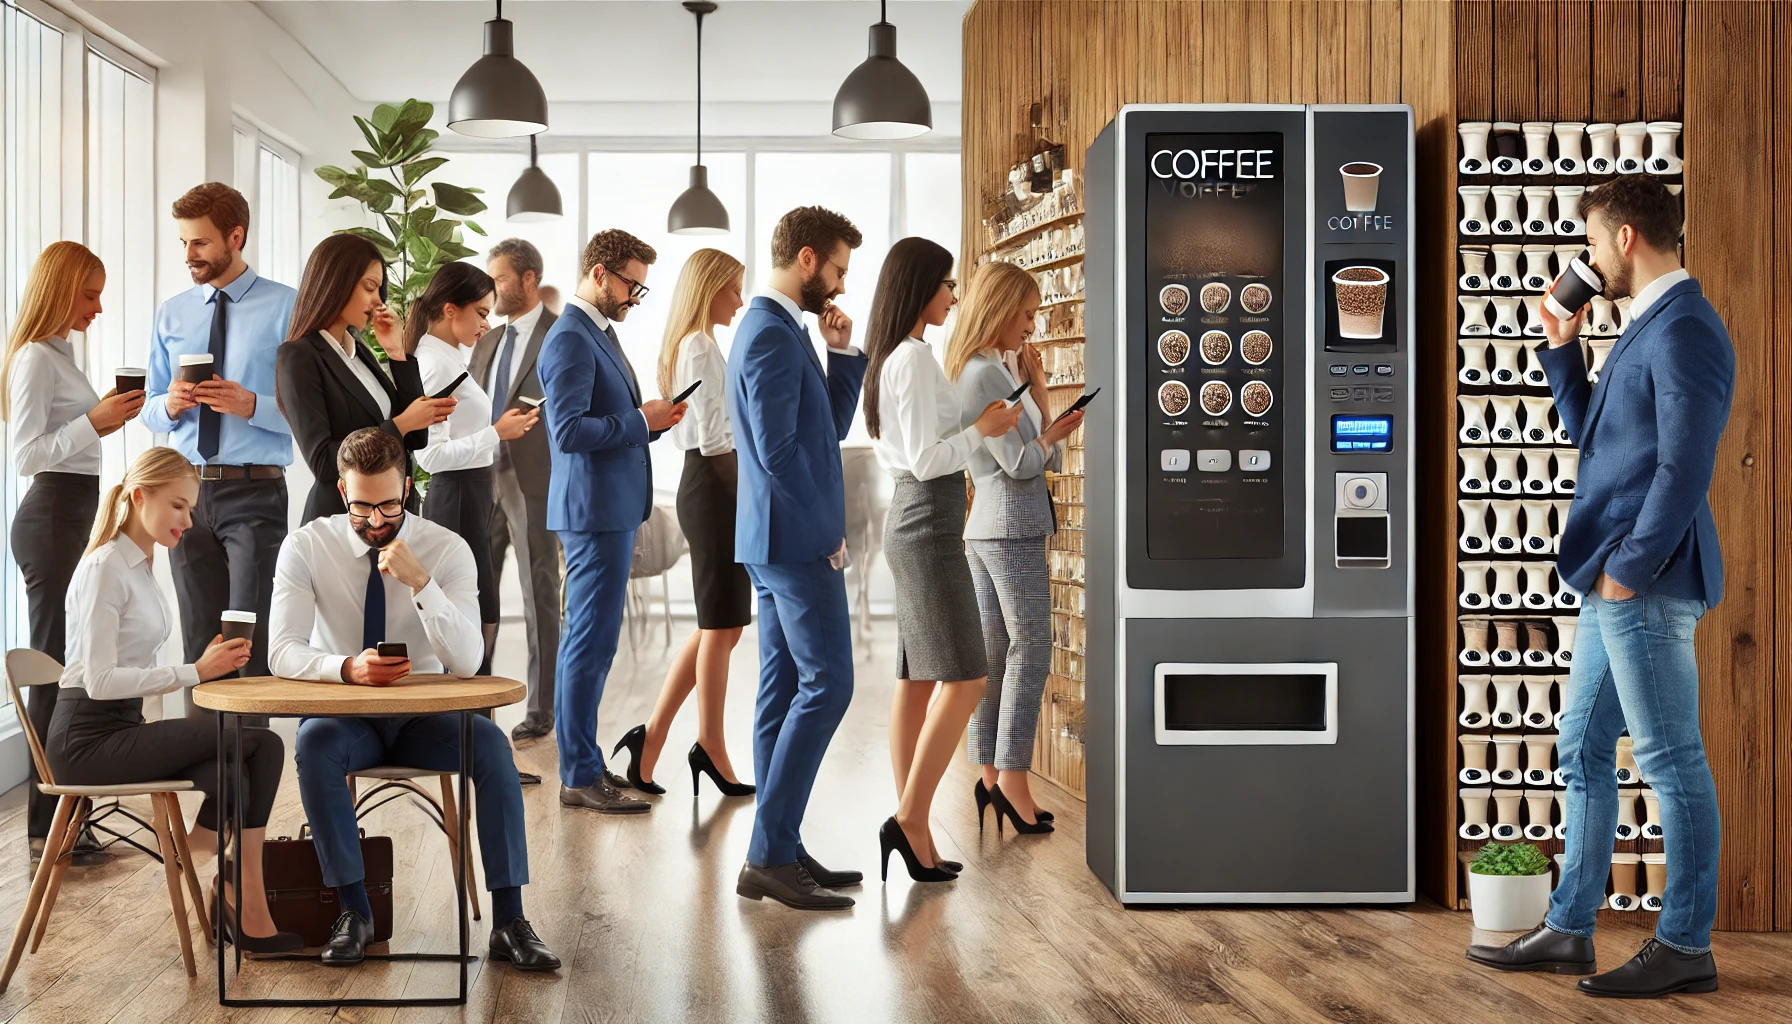

In [ ]:
# @title
!pip install kneed

In [2]:
# @title
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
import seaborn as sns
import kagglehub
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from kneed import KneeLocator
import warnings
warnings.filterwarnings('ignore')

try:
  _ = path
except:
  # Download the data using kaggle APIs
  path = kagglehub.dataset_download("ihelon/coffee-sales")

path1 = path + '/' + os.listdir(path)[0]
path2 = path + '/' + os.listdir(path)[1]

# Fetch the datasets as pandas Dataframes
df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)

# Data Preprocessing Section
# Unify the name of categories in columns coffee_name between df1 and df2
df1.replace('Americano with milk', 'Americano with Milk', inplace=True)

# Concate the two dataframes into dataframe
data = pd.concat([df2, df1], axis=0).reset_index(drop=True)

# Convert the date column type to appropriate type
data['date'] = pd.to_datetime(data['date']).dt.date

# Svae variable of introducing new version of caffee (the start date of df1 dataframe)
cut_off = "2025-02-08"
cut_off = pd.to_datetime(cut_off).date()

#display(data.head())
#print("="*60)
#display(data.info())


# Core metrics
total_sales = len(data)
total_return = data.money.sum()
start_date = data.date.min()
end_date = data.date.max()
duration_days = (end_date - start_date).days
avg_daily_sales = total_sales / duration_days
avg_daily_return = total_return / duration_days

print("📈 EXECUTIVE SUMMARY")
print("═" * 60)
print(f"   • 📊 Total Sales: {total_sales:,} transactions")
print(f"   • 💰 Total Return: ${total_return:,.2f}")
print(f"   • 📅 Total Period: {duration_days} days - Start Date: {start_date} - End Date: {end_date}")
print(f"   • 🎯 Daily Average: {avg_daily_sales:.0f} sales - (${avg_daily_return:.2f} return)")

100%|██████████| 42.9k/42.9k [00:00<00:00, 20.1MB/s]

Extracting files...
📈 EXECUTIVE SUMMARY
════════════════════════════════════════════════════════════
   • 📊 Total Sales: 3,898 transactions
   • 💰 Total Return: $122,321.58
   • 📅 Total Period: 387 days - Start Date: 2024-03-01 - End Date: 2025-03-23
   • 🎯 Daily Average: 10 sales - ($316.08 return)


Over a 387-day period from March 1, 2024, to March 23, 2025, the vending machine demonstrated consistent performance by generating a total return of 122,321.58 from 3,898 transactions. This equates to a daily average of 10 sales and approximately 316 in return per day.

### Product Performance

In [3]:
# @title
no_all_coffee = data['coffee_name'].nunique()
no_old_version_coffee = data[data['date']<cut_off]['coffee_name'].nunique()
no_new_version_coffee = data[data['date']>=cut_off]['coffee_name'].nunique()

print(f'Number of all coffee types: {no_all_coffee}')
print(f'Number of old version cofffee: {no_old_version_coffee}')
print(f'Number of types after introducing new kind of coffee: {no_new_version_coffee}')
print(f'Number of new version cofffee: {no_all_coffee - no_old_version_coffee}')

Number of all coffee types: 33
Number of old version cofffee: 8
Number of types after introducing new kind of coffee: 33
Number of new version cofffee: 25


The new coffee launch dramatically expanded the menu from 8 to 33 types, introducing 25 new varieties while retaining all original offerings.

In [4]:
# @title
# Helper function
def analyze_coffee_performance(data):
    """Analyze coffee performance for a given dataset"""
    value_counts = data.coffee_name.value_counts().to_frame(name='Total purchases')
    total_count = value_counts['Total purchases'].sum()
    value_counts['percentage'] = (value_counts['Total purchases'] / total_count * 100).round(2)

    money_sums = data.groupby('coffee_name')['money'].sum().sort_values(ascending=False).to_frame(name='Total returns')
    total_money = money_sums['Total returns'].sum()
    money_sums['percentage'] = (money_sums['Total returns'] / total_money * 100).round(2)

    money_mean = data.groupby('coffee_name')['money'].mean().sort_values(ascending=False).to_frame(name='Average Price')

    return value_counts, money_sums, money_mean, total_count, total_money

def create_coffee_hbar_chart(ax, labels, values, title, xlabel, is_money=False, total_ref=None):
    """Create a standardized horizontal bar chart for coffee data"""
    y_pos = np.arange(len(labels))

    bars = ax.barh(y_pos, values,
                  color=plt.cm.Set3(np.linspace(0, 1, len(labels))),
                  alpha=0.8, edgecolor='white', linewidth=2)

    max_value = max(values)
    for i, (bar, value) in enumerate(zip(bars, values)):
        percentage = (value / total_ref) * 100
        label = f'${value:,.0f} ({percentage:.1f}%)' if is_money else f'{value:,} ({percentage:.1f}%)'

        # Position text at the end of the bar
        ax.text(bar.get_width() + max_value * 0.01, bar.get_y() + bar.get_height()/2,
                label, ha='left', va='center', fontweight='bold', fontsize=9)

    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel(xlabel, fontsize=12, labelpad=10)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.grid(axis='x', alpha=0.2, linestyle='--')
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlim(0, max_value * 1.25)

    # Invert y-axis to show highest values at the top
    ax.invert_yaxis()

def results_analysis(data, title):
    """Analyze and display coffee performance results with visualizations"""
    # Check if data is empty
    if data.empty:
        print(f"No data available for {title}")
        return

    # Analyze coffee types performance
    counts, money, mean, total_count, total_money = analyze_coffee_performance(data)
    top_5_counts = counts.head(5)
    top_5_counts.loc['Sum'] = [top_5_counts['Total purchases'].sum(), top_5_counts['percentage'].sum()]
    top_5_counts['percentage'] = top_5_counts['percentage'].apply(lambda x: f'{x:0.02f}%')
    top_5_money = money.head(5)
    top_5_money.loc['Sum'] = [top_5_money['Total returns'].sum(), top_5_money['percentage'].sum()]
    top_5_money['percentage'] = top_5_money['percentage'].apply(lambda x: f'{x:0.02f}%')

    # Display the results
    print()
    print("═" * 60)
    print(f"      🏷️ {title}")
    print()
    print(f"   • 📊 Number of coffee types: {data.coffee_name.nunique()} unique types")
    print(f"   • Transactions: {total_count:,}, return: ${total_money:,.0f}")
    print(f"   • Top 5 Most Purchased Coffees")
    display(top_5_counts)
    display(top_5_money)
    print()

    # Create visualizations with horizontal bar charts
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)


    # Horizontal bar chart for transaction counts
    create_coffee_hbar_chart(ax[0], counts.index, counts['Total purchases'].values,
                            'Coffee Types: Transaction Count', 'Number of Transactions',
                            False, total_count)

    # Horizontal bar chart for return
    create_coffee_hbar_chart(ax[1], money.index, money['Total returns'].values,
                            'Coffee Types: Total return', 'Total return ($)',
                            True, total_money)

    plt.tight_layout()
    plt.show()

old_version_coffee = df2.coffee_name.unique()
new_version_coffee = [coffee for coffee in df1.coffee_name.unique() if coffee not in old_version_coffee]
old_version = data[data['coffee_name'].isin(old_version_coffee)]
new_version = data[data['coffee_name'].isin(new_version_coffee)]
after_intro_new_version = data[data['date'] >= cut_off]


════════════════════════════════════════════════════════════
      🏷️ All Coffee Performance Analysis

   • 📊 Number of coffee types: 33 unique types
   • Transactions: 3,898, return: $122,322
   • Top 5 Most Purchased Coffees


,Total purchases,percentage
coffee_name,,
Americano with Milk,868.0,22.27%
Latte,806.0,20.68%
Americano,593.0,15.21%
Cappuccino,517.0,13.26%
Cortado,292.0,7.49%
Sum,3076.0,78.91%


,Total returns,percentage
coffee_name,,
Latte,28658.30,23.43%
Americano with Milk,26369.12,21.56%
Cappuccino,18514.14,15.14%
Americano,15437.26,12.62%
Hot Chocolate,10172.46,8.32%
Sum,99151.28,81.07%


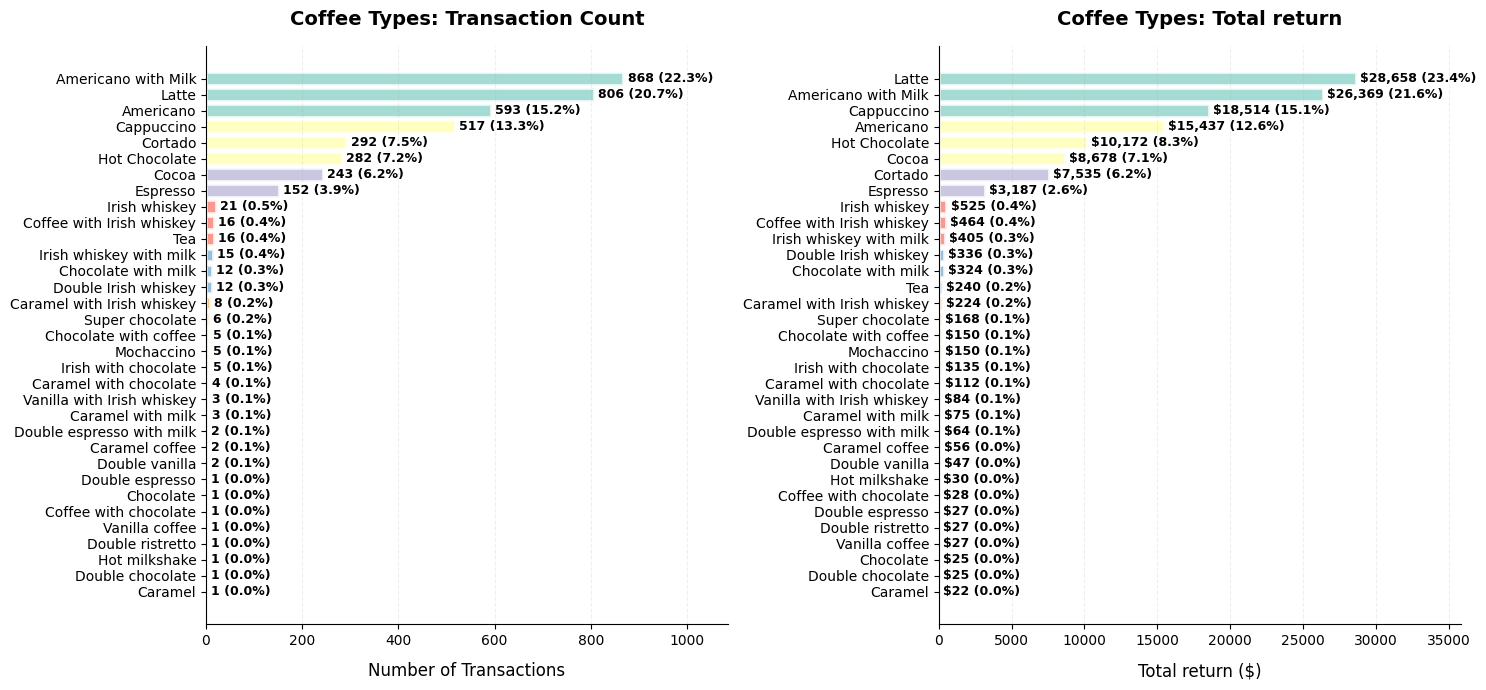

In [5]:
# @title
results_analysis(data, "All Coffee Performance Analysis")

Top 5 most purcase coffee type:
1. Americano with Milk
2. Latte
3. Americano
4. Cappuccino
5. Hot Chocolate

Top 5 most purcase coffee type:
1. Latte
2. Americano with Milk
3. Cappuccino
4. Americano
5. Hot Chocolate

those coffee types represt approximately 3076 purchases porcess about(78.91%)  from all purchases processes 3898. The total revenue for those top 5 is about 99151.28	(81.07%)




════════════════════════════════════════════════════════════
      🏷️ Old Version Coffee Performance Analysis

   • 📊 Number of coffee types: 8 unique types
   • Transactions: 3,753, return: $118,552
   • Top 5 Most Purchased Coffees


,Total purchases,percentage
coffee_name,,
Americano with Milk,868.0,23.13%
Latte,806.0,21.48%
Americano,593.0,15.80%
Cappuccino,517.0,13.78%
Cortado,292.0,7.78%
Sum,3076.0,81.97%


,Total returns,percentage
coffee_name,,
Latte,28658.30,24.17%
Americano with Milk,26369.12,22.24%
Cappuccino,18514.14,15.62%
Americano,15437.26,13.02%
Hot Chocolate,10172.46,8.58%
Sum,99151.28,83.63%


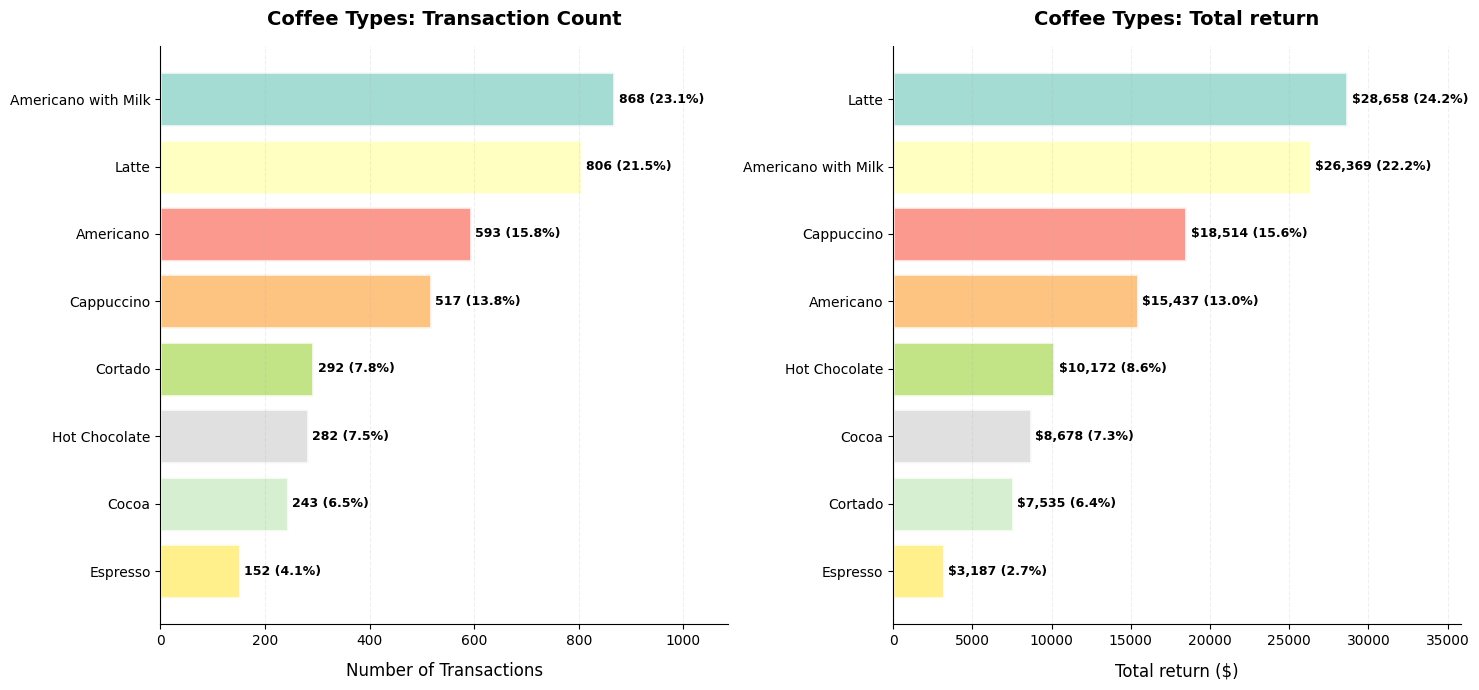

In [6]:
# @title
results_analysis(old_version, "Old Version Coffee Performance Analysis")

## ☕ Old Version Coffee Performance Analysis

## 1. Transaction Count (Customer Preference by Volume)
- **Americano with Milk (23.1%)** and **Latte (21.5%)** are top sellers (~45% combined).  
- **Americano (15.8%)** and **Cappuccino (13.8%)** make up the second tier (~30%).  
- Niche drinks (**Cortado, Hot Chocolate, Cocoa, Espresso**) each contribute <8%.  

📌 **Key Insight:** Customers prefer **milk-based drinks** (Americano with Milk, Latte, Cappuccino) over plain espresso or cocoa options.

---

## 2. Total Return (Revenue Contribution)
- **Latte (28,658; 24.2%)** is the highest revenue generator.  
- **Americano with Milk (26,369; 22.2%)** ranks second.  
- **Cappuccino (18,514; 15.6%)** earns more than **Americano (15,437; 13.0%)**, despite fewer sales → higher unit price.  
- **Hot Chocolate (10,172; 8.6%)** and **Cocoa (8,678; 7.3%)** add meaningful contributions.  
- **Espresso (3,187; 2.7%)** is lowest in both volume and revenue.  

---

## 3. Strategic Insights
- **Milk-based beverages dominate** → ensuring consistent stock is critical and investing more in this kinds of coffee like introducing new milk-based types  
- **Diversification matters:** Cocoa & Hot Chocolate serve non-coffee drinkers.  
- **Espresso underperforms** → candidate for reduced stock/space allocation and studing why (product, price, stock, technical issues, marketing) this product underperforms amonge other types.  

---

## 4. Recommendations & Opportunities

### Inventory Optimization
- Keep **Latte & Americano with Milk** fully stocked.  
- Reduce **Espresso** stock to minimize waste.  

### Profitability Enhancement
- Consider **premium pricing** for high-demand drinks (Latte, Americano with Milk).  

### Customer Experience & Mix
- Retain **Hot Chocolate & Cocoa** to attract non-coffee customers.  
- Invest in milk-based types and introduce new milk-based types like **seasonal flavors** (e.g., spiced latte, flavored cocoa) to boost novelty purchases.  

---

## ✅ Summary
- **Focus:** Keep bestsellers stocked.
- **Optimize:** Reduce Espresso allocation, maintain variety with Cocoa & Hot Chocolate.  
- **Grow:** Use pricing strategies & seasonal products to lift revenue.


════════════════════════════════════════════════════════════
      🏷️ New Version Performance Analysis

   • 📊 Number of coffee types: 25 unique types
   • Transactions: 145, return: $3,770
   • Top 5 Most Purchased Coffees


,Total purchases,percentage
coffee_name,,
Irish whiskey,21.0,14.48%
Coffee with Irish whiskey,16.0,11.03%
Tea,16.0,11.03%
Irish whiskey with milk,15.0,10.34%
Chocolate with milk,12.0,8.28%
Sum,80.0,55.16%


,Total returns,percentage
coffee_name,,
Irish whiskey,525.0,13.93%
Coffee with Irish whiskey,464.0,12.31%
Irish whiskey with milk,405.0,10.74%
Double Irish whiskey,336.0,8.91%
Chocolate with milk,324.0,8.59%
Sum,2054.0,54.48%


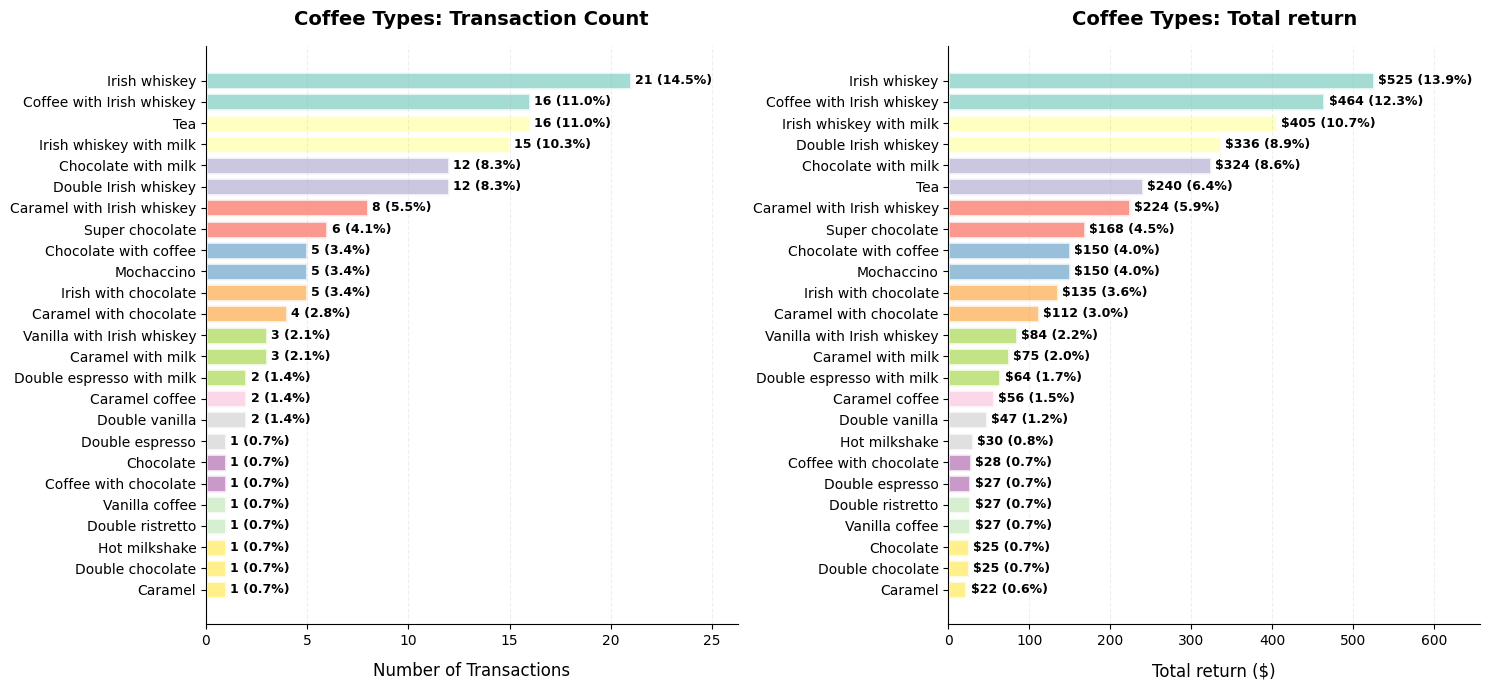

In [7]:
# @title
results_analysis(new_version, "New Version Performance Analysis")

## ☕ New Coffee Collection Analysis (Launched Feb 8, 2025)

## 1. Transaction Count (Customer Preference by Volume)
- **Irish Whiskey (14.5%)** is the top-selling product.
- **Coffee with Irish Whiskey (11.0%)** and **Tea (11.0%)** follow closely.
- **Irish Whiskey with Milk (10.3%)**, **Chocolate with Milk (8.3%)**, and **Double Irish Whiskey (8.3%)** form the second tier.
- Specialty mixes like **Caramel with Irish Whiskey (5.5%)** and **Super Chocolate (4.1%)** show moderate demand.
- Most other drinks (Caramel, Espresso variants, Vanilla types) are niche (<3%).

📌 **Key Insight:** Irish Whiskey–inspired drinks dominate, with milk-based and premium flavors driving demand.

---

## 2. Total Return (Revenue Contribution)
- **Irish Whiskey (525; 13.9%)** is the highest revenue contributor.
- **Coffee with Irish Whiskey (464; 12.3%)** and **Irish Whiskey with Milk (405; 10.7%)** rank next.
- **Double Irish Whiskey (336; 8.9%)** and **Chocolate with Milk (324; 8.6%)** add strong returns.
- **Caramel with Irish Whiskey (224; 5.9%)** and **Super Chocolate (168; 4.5%)** deliver moderate contributions.
- Lower-tier drinks each generate **<1% of total revenue**.

📌 **Key Insight:** The **Irish Whiskey line dominates revenue**, showing customers are willing to pay more for premium specialty coffee.

---

## 3. Strategic Observations
- **Irish Whiskey Collection = clear success** → strong across volume and revenue.
- **Tea performs surprisingly well** → strong adoption among non-coffee drinkers.
- **Chocolate-based drinks** contribute moderately, offering indulgence appeal.
- **Caramel and niche variants underperform** (<3% volume, <2% revenue).

---

## 4. Recommendations & Opportunities
- **Double down on Irish Whiskey line**: Keep stock high, explore new seasonal variations (e.g., Irish Whiskey Mocha).
- **Expand Tea offerings**: Add flavored/herbal teas to capture wider audience.
- **Promote Chocolate drinks**: Position as indulgent alternatives and use in bundles.
- **Streamline low performers**: Reduce space for Caramel coffee, Double Vanilla, Ristretto, etc.
- **Optimize pricing**: Test small price increases for Irish Whiskey-based drinks to boost margins.

---

## ✅ Summary
The new **Irish Whiskey collection is a major hit**, dominating both transactions and revenue.  
**Tea and Chocolate drinks provide strong secondary growth**, while niche items underperform.  
**Focus on premium Irish Whiskey products, expand tea, and streamline low performers** to maximize revenue.


════════════════════════════════════════════════════════════
      🏷️ Performance After Launching New Version

   • 📊 Number of coffee types: 33 unique types
   • Transactions: 897, return: $26,677
   • Top 5 Most Purchased Coffees


,Total purchases,percentage
coffee_name,,
Americano,218.0,24.30%
Americano with Milk,155.0,17.28%
Latte,121.0,13.49%
Cappuccino,95.0,10.59%
Cocoa,68.0,7.58%
Sum,657.0,73.24%


,Total returns,percentage
coffee_name,,
Americano,5644.88,21.16%
Americano with Milk,4525.46,16.96%
Latte,4260.72,15.97%
Cappuccino,3305.04,12.39%
Cocoa,2431.68,9.12%
Sum,20167.78,75.60%


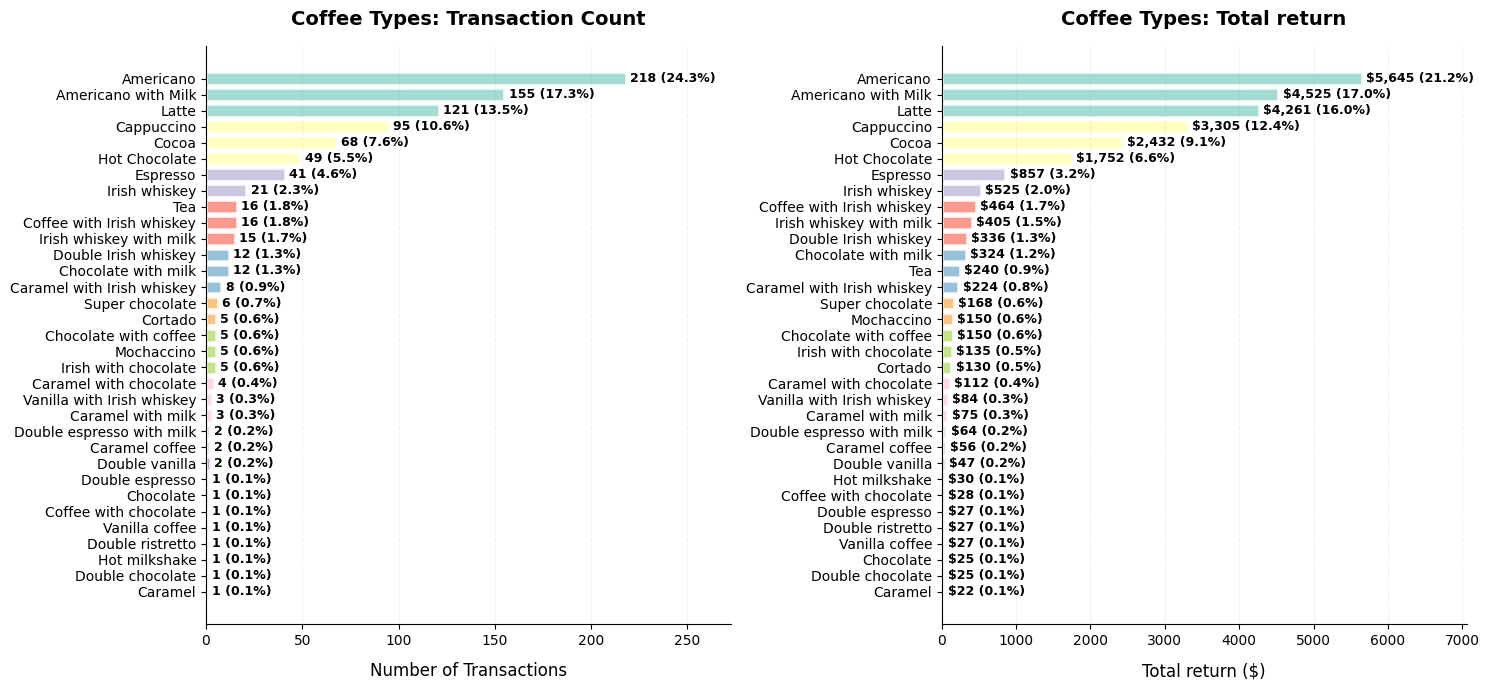

In [8]:
# @title
results_analysis(after_intro_new_version, "Performance After Launching New Version")

# ☕ Coffee Sales Analysis: Old vs. New Collection (After Feb 8, 2025)

🏷️ Performance After Launch:
- 📊 Number of coffee types: **33 unique types**
- 🛒 Transactions: **897**
- 💵 Total Return: **26,677**

---

## 1. Transaction Count (Customer Preference by Volume)
- **Americano (24.3%)** and **Americano with Milk (17.3%)** dominate sales (~42% combined).
- **Latte (13.5%)** and **Cappuccino (10.6%)** remain strong (~24% combined).
- **Cocoa (7.6%)** and **Hot Chocolate (5.5%)** are solid niche favorites.
- **New Irish Whiskey drinks**: modest traction (Irish Whiskey 2.3%, Coffee with Irish Whiskey 1.8%, Irish Whiskey with Milk 1.7%).
- Most other new types contribute **<1%** of sales.

📌 **Insight:** Traditional core drinks still dominate, while new collection shows limited adoption.

---

## 2. Total Return (Revenue Contribution)
- **Americano (5,645; 21.2%)** is top revenue driver.
- **Americano with Milk (4,525; 17.0%)**, **Latte (4,261; 16.0%)**, and **Cappuccino (3,305; 12.4%)** follow.
- **Cocoa (2,432; 9.1%)** and **Hot Chocolate (1,752; 6.6%)** add steady returns.
- **New Irish Whiskey products** contribute modestly:
  - Irish Whiskey: 525 (2.0%)
  - Coffee with Irish Whiskey: 464 (1.7%)
  - Irish Whiskey with Milk: 405 (1.5%)
- Many other new drinks remain **<1% of revenue each**.

📌 **Insight:** Core drinks generate >65% of revenue. New types remain niche contributors.

---

## 3. Strategic Observations
- **Core products dominate** → Americano, Latte, Cappuccino, Americano with Milk are still the anchors.
- **New collection impact limited** → Irish Whiskey line has some traction but modest revenue.
- **Cocoa & Hot Chocolate reliable** → important for non-coffee customers.
- **Over-diversification risk** → 33 types, many under 1% share, adds complexity.

---

## 4. Recommendations & Opportunities
1. **Protect the Core**: Keep Americano, Americano with Milk, Latte, Cappuccino stocked and reliable.
2. **Selective Promotion**: Focus on Irish Whiskey line (bundle deals, seasonal campaigns).
3. **Streamline Portfolio**: Phase out or rotate very low-selling drinks (<1% contribution).
4. **Enhance Non-Coffee Options**: Explore seasonal Cocoa/Hot Chocolate variations.
5. **Monitor New Collection**: Track Irish Whiskey growth before expanding further.

---

## ✅ Summary
- **Traditional drinks remain dominant** → core products still drive majority of sales and revenue.
- **New collection adds variety but limited impact** → Irish Whiskey shows potential, others underperform.
- **Opportunity**: Double down on top-sellers, selectively promote Irish Whiskey, and streamline the portfolio for efficiency.

## Payment Methods Analysis

All Period Analysis
💳 PAYMENT & FINANCIAL METRICS
════════════════════════════════════════════════════════════
   • Payment Methods: 2 types
   • Cash Types: ['card', 'cash']
════════════════════════════════════════════════════════════

Payment Methods Analysis:
  • card: 2,912 transactions (97.0%) - Total Return $92,458 (96.7%)
  • cash: 89 transactions (3.0%) - Total Return $3,186 (3.3%)



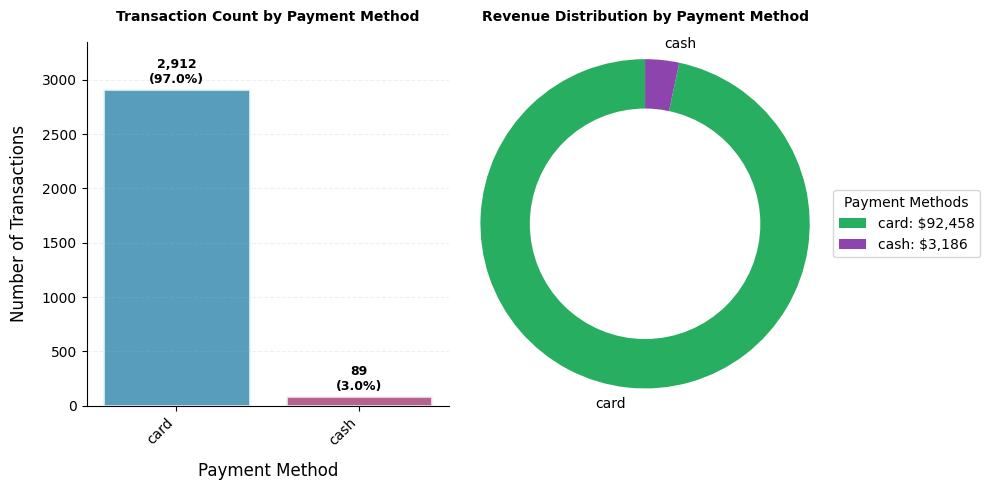

════════════════════════════════════════════════════════════
After Introducing New Coffee types
💳 PAYMENT & FINANCIAL METRICS
════════════════════════════════════════════════════════════
   • Payment Methods: 2 types
   • Cash Types: ['card', 'cash']
════════════════════════════════════════════════════════════

Payment Methods Analysis:
  • card: 817 transactions (91.1%) - Total Return $24,656 (92.4%)
  • cash: 80 transactions (8.9%) - Total Return $2,021 (7.6%)



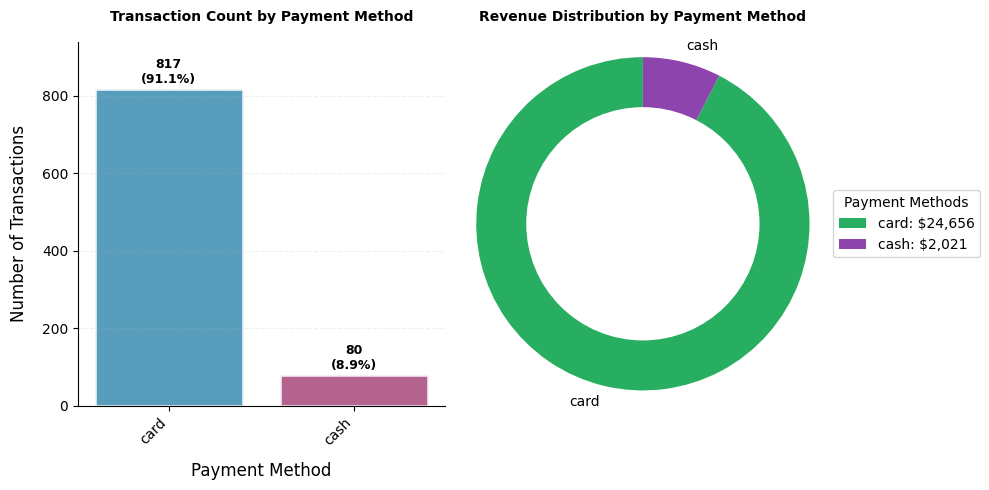

In [9]:
# @title
# Payment Methods Performance Analysis
def payment_method_analysis(data):
    # Create figure with better spacing
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # Increased width for pie chart
    plt.subplots_adjust(wspace=0.3, hspace=0.4, bottom=0.15)

    # Get value counts and money sums
    value_counts = data.cash_type.value_counts()
    money_sums = data.groupby('cash_type')['money'].sum()
    total_count = value_counts.sum()
    total_money = money_sums.sum()

    # Print detailed insights in console
    print("💳 PAYMENT & FINANCIAL METRICS")
    print("═" * 60)
    print(f"   • Payment Methods: {len(value_counts)} types")
    print(f"   • Cash Types: {value_counts.index.tolist()}")
    print("═" * 60)
    print()

    print("Payment Methods Analysis:")
    for i, (cash_type, count) in enumerate(value_counts.items()):
        money_sum = money_sums[cash_type]
        percentage_count = (count / total_count) * 100
        percentage_sum = (money_sum / total_money) * 100
        print(f"  • {cash_type}: {count:,} transactions ({percentage_count:.1f}%) - Total Return ${money_sum:,.0f} ({percentage_sum:.1f}%)")
    print()

    # --- BAR CHART 1: Transaction Count (Left) ---
    bars1 = ax1.bar(range(len(value_counts)), value_counts.values,
                  color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'][:len(value_counts)],
                  alpha=0.8, edgecolor='white', linewidth=2)

    # Add annotations with percentages
    for i, (bar, count) in enumerate(zip(bars1, value_counts.values)):
        percentage = (count / total_count) * 100
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(value_counts.values)*0.01,
                f'{count:,}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

    ax1.set_title('Transaction Count by Payment Method', fontsize=10, fontweight='bold', pad=15)
    ax1.set_xlabel('Payment Method', fontsize=12, labelpad=10)
    ax1.set_ylabel('Number of Transactions', fontsize=12, labelpad=10)
    ax1.set_xticks(range(len(value_counts)))
    ax1.set_xticklabels(value_counts.index, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.2, linestyle='--')
    ax1.spines[['top', 'right']].set_visible(False)
    ax1.set_ylim(0, max(value_counts.values) * 1.15)

    # --- PIE CHART 2: Revenue Distribution (Right) ---
    colors = ['#27AE60', '#8E44AD', '#E67E22', '#C0392B', '#3498DB', '#F1C40F'][:len(money_sums)]
    wedges, texts, autotexts = ax2.pie(money_sums.values,
                                      labels=money_sums.index,
                                      autopct='%1.1f%%',
                                      colors=colors,
                                      startangle=90,
                                      textprops={'fontsize': 10})

    # Style the percentage text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)

    # Add a donut hole
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax2.add_artist(centre_circle)

    ax2.set_title('Revenue Distribution by Payment Method', fontsize=10, fontweight='bold', pad=15)
    ax2.axis('equal')  # Ensure pie is drawn as a circle

    # Add legend with actual values
    legend_labels = [f'{label}: ${value:,.0f}' for label, value in zip(money_sums.index, money_sums.values)]
    ax2.legend(wedges, legend_labels, title="Payment Methods", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    plt.tight_layout()
    plt.show()

# Display the results
print("All Period Analysis")
before_new_products = data[data['date']<cut_off]
after_new_products = data[data['date']>=cut_off]
payment_method_analysis(before_new_products)
print("═" * 60)
print("After Introducing New Coffee types")
payment_method_analysis(after_new_products)

## TEMPORAL ANALYSIS & TRENDS

📊 COMPREHENSIVE DAILY COUNT ANALYSIS

📈 BASIC STATISTICS:
   Total period: 381 days
   Total records: 3,898
   Average per day: 10.2
   Busiest day: 35 records
   Quietest day: 1 records
   Standard deviation: 6.1

🎯 ADVANCED INSIGHTS:
   Coefficient of Variation: 59.9%
   Skewness: 1.17
   Kurtosis: 1.47

📅 RECENT TRENDS:
   Last 7 days avg: 21.4
   Previous 7 days avg: 18.6
   Trend: ↑ 15.4%

⚠️  OUTLIER DETECTION:
   21 outlier days detected
   Outlier range: 24 - 35

📊 DISTRIBUTION SHAPE:
   Highly skewed (right-skewed)


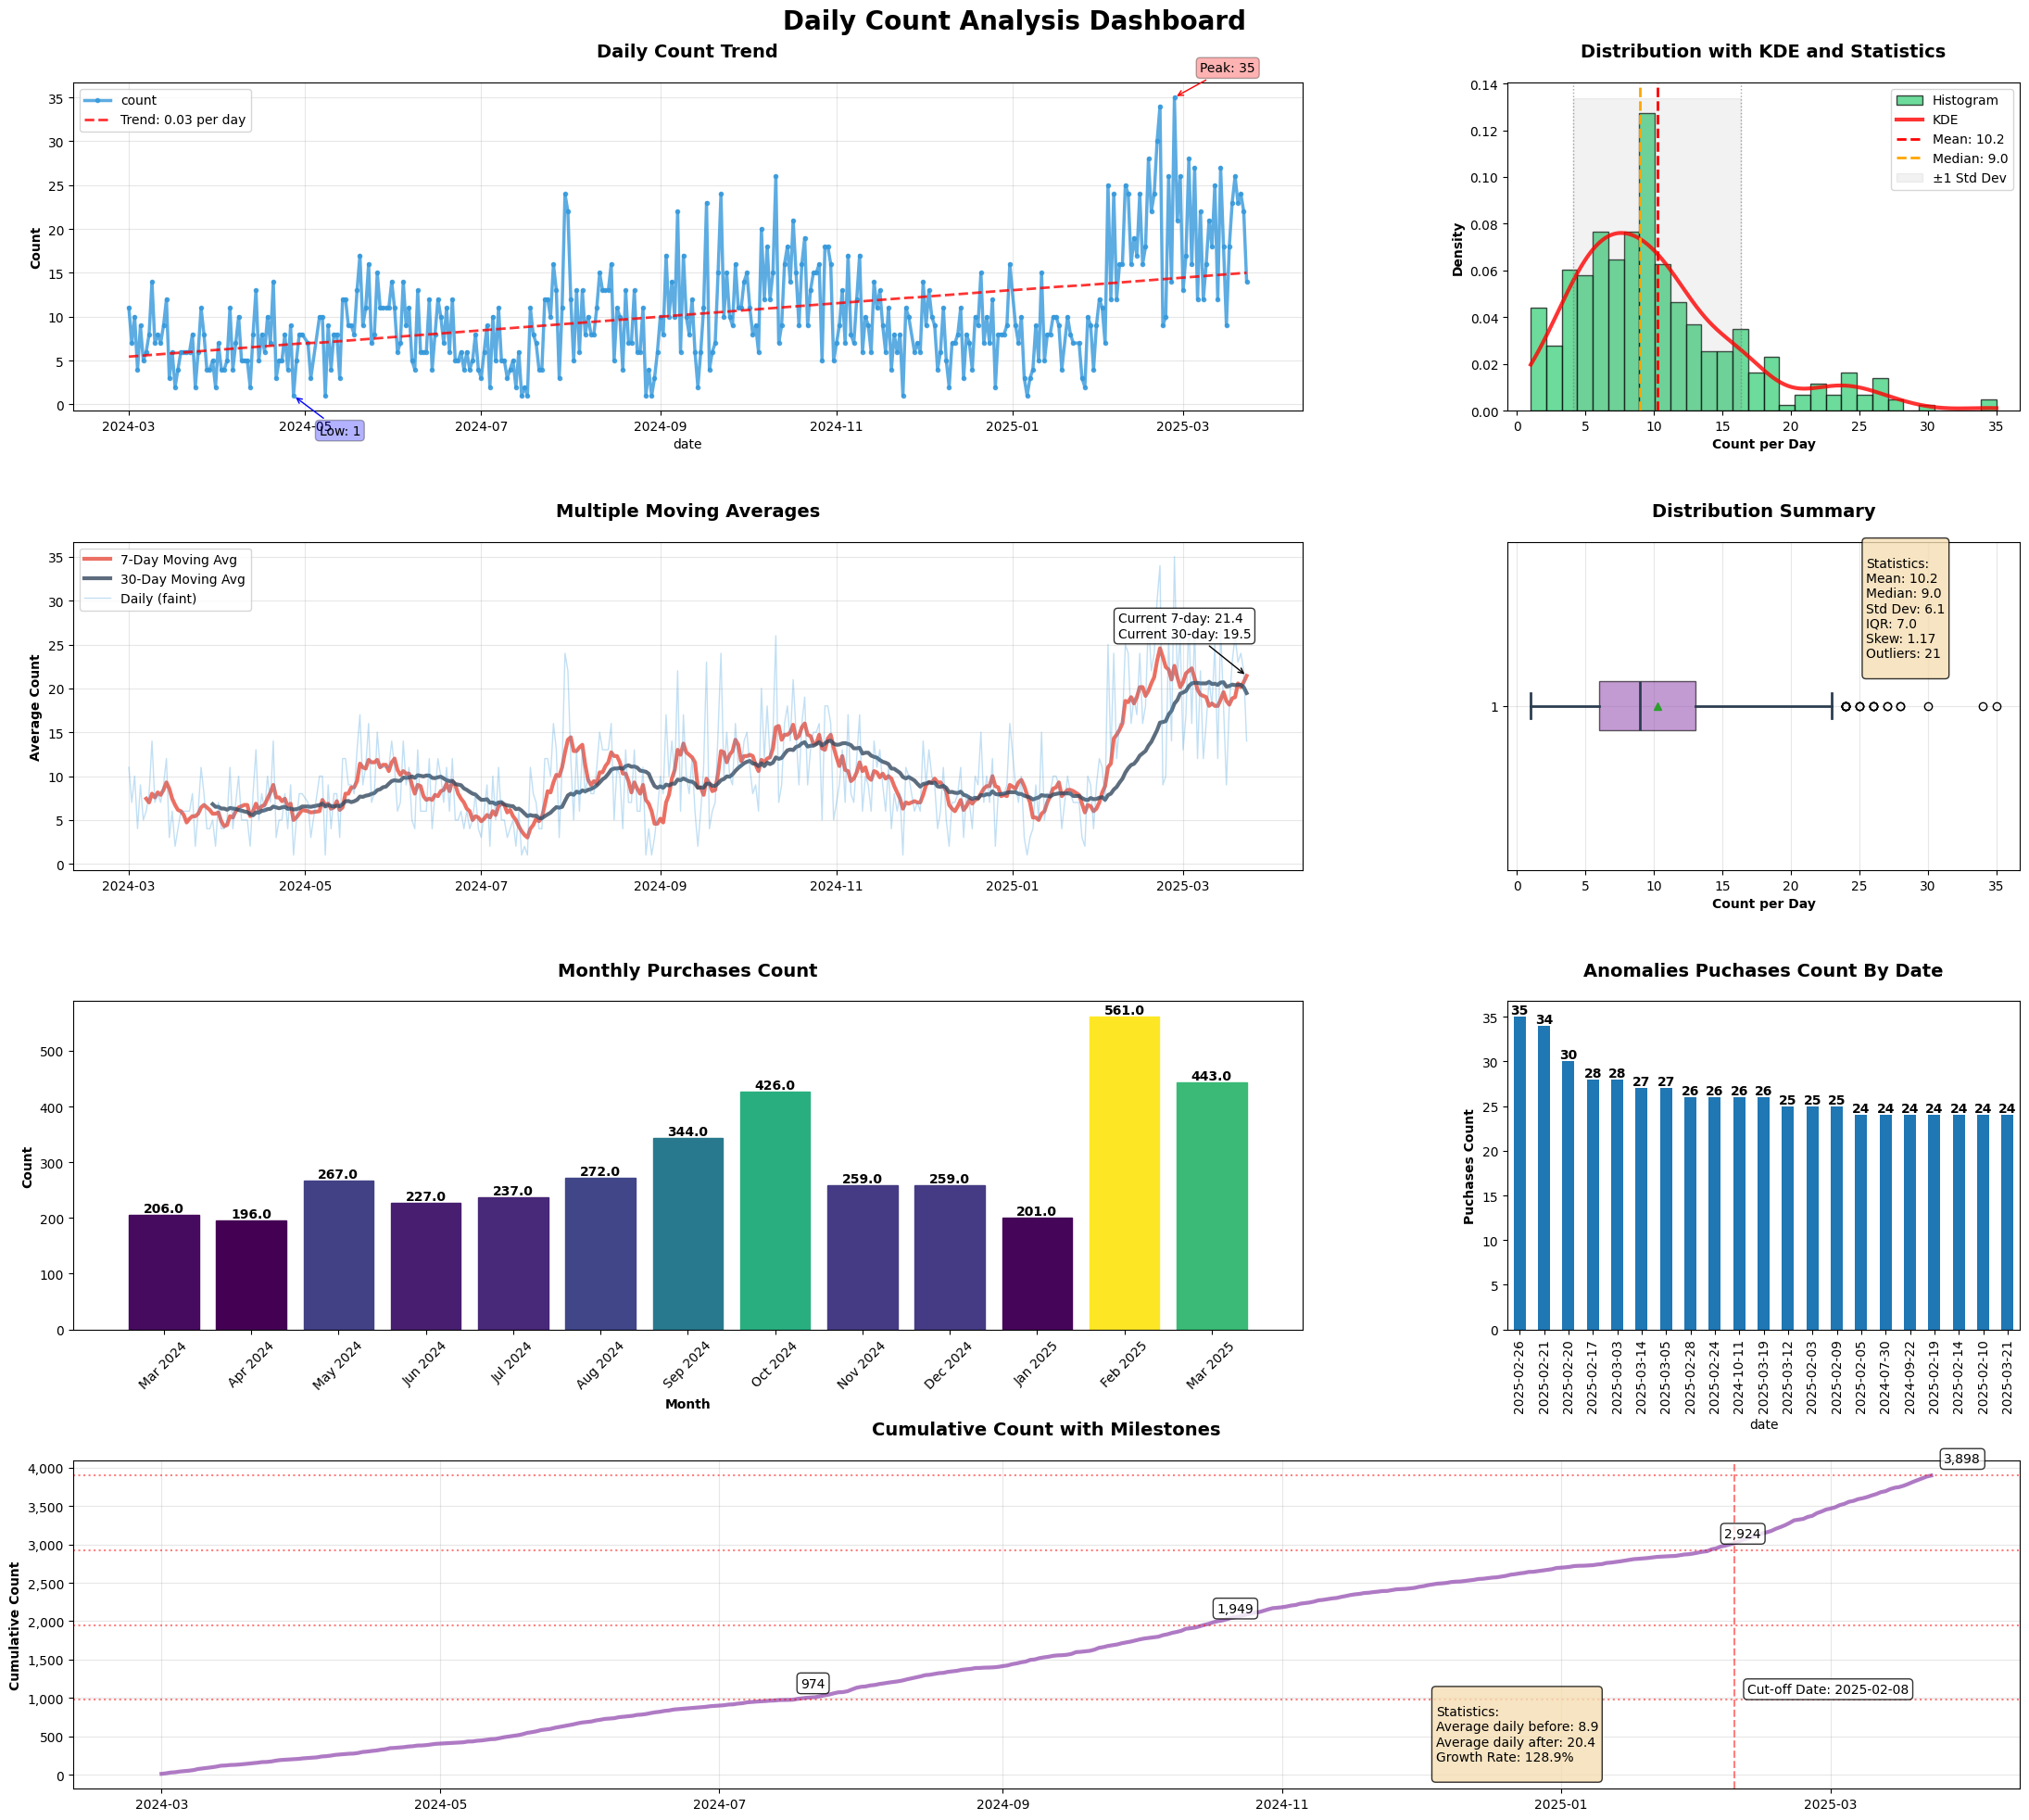

In [10]:
# @title
# Prepare data
daily_counts = data.groupby('date').agg(count=("date", "count"))

# Create figure with better layout
fig = plt.figure(figsize=(22, 20))
fig.suptitle('Daily Count Analysis Dashboard', fontsize=20, fontweight='bold', y=0.98)

# Create subplots grid - fixed to match actual usage
ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((4, 3), (0, 2))
ax3 = plt.subplot2grid((4, 3), (1, 0), colspan=2)
ax4 = plt.subplot2grid((4, 3), (1, 2))
ax5 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax6 = plt.subplot2grid((4, 3), (2, 2))
ax7 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

# Format function for large numbers
def thousands_formatter(x, pos):
    return f'{x:,.0f}'

# 1. Main trend line with enhanced features
daily_counts.plot(kind='line', ax=ax1, linewidth=2.5, color='#3498db', alpha=0.8, marker='o', markersize=3)
ax1.set_title('Daily Count Trend', fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Count', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(['Daily Count'], loc='upper left')

# Add trend line
z = np.polyfit(range(len(daily_counts)), daily_counts['count'], 1)
p = np.poly1d(z)
ax1.plot(daily_counts.index, p(range(len(daily_counts))), "r--", alpha=0.8, linewidth=2,
        label=f'Trend: {z[0]:.2f} per day')

# Add annotations for peaks and troughs
max_idx = daily_counts['count'].idxmax()
min_idx = daily_counts['count'].idxmin()
ax1.annotate(f'Peak: {daily_counts["count"].max():,}',
            xy=(max_idx, daily_counts["count"].max()),
            xytext=(20, 20), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3),
            arrowprops=dict(arrowstyle='->', color='red'))
ax1.annotate(f'Low: {daily_counts["count"].min():,}',
            xy=(min_idx, daily_counts["count"].min()),
            xytext=(20, -30), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.3),
            arrowprops=dict(arrowstyle='->', color='blue'))

ax1.legend()

# 2. Enhanced Distribution histogram with KDE
counts = daily_counts['count'].dropna()
n_bins = min(30, len(counts) // 5)  # Adaptive bin count

# Histogram
n, bins, patches = ax2.hist(counts, bins=n_bins, alpha=0.7, color='#2ecc71',
                           edgecolor='black', density=True, label='Histogram')

# KDE plot
kde = stats.gaussian_kde(counts)
x_range = np.linspace(counts.min(), counts.max(), 1000)
ax2.plot(x_range, kde(x_range), 'r-', linewidth=3, label='KDE', alpha=0.8)

ax2.set_title('Distribution with KDE and Statistics', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Count per Day', fontweight='bold')
ax2.set_ylabel('Density', fontweight='bold')
ax2.legend()

# Add statistical lines
mean_val = counts.mean()
median_val = counts.median()
std_val = counts.std()
ax2.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
ax2.axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
ax2.axvline(mean_val + std_val, color='gray', linestyle=':', linewidth=1, alpha=0.7)
ax2.axvline(mean_val - std_val, color='gray', linestyle=':', linewidth=1, alpha=0.7)
ax2.fill_betweenx([0, ax2.get_ylim()[1]], mean_val-std_val, mean_val+std_val,
                 alpha=0.1, color='gray', label='±1 Std Dev')

ax2.legend()

# 3. Enhanced Rolling averages
window_7 = daily_counts['count'].rolling(window=7).mean()
window_30 = daily_counts['count'].rolling(window=30).mean()

ax3.plot(daily_counts.index, window_7, color='#e74c3c', linewidth=3, label='7-Day Moving Avg', alpha=0.8)
ax3.plot(daily_counts.index, window_30, color='#34495e', linewidth=3, label='30-Day Moving Avg', alpha=0.8)
ax3.plot(daily_counts.index, daily_counts['count'], color='#3498db', linewidth=1, alpha=0.3, label='Daily (faint)')

ax3.set_title('Multiple Moving Averages', fontsize=14, fontweight='bold', pad=20)
ax3.set_ylabel('Average Count', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add current values annotation
if len(window_7) > 0:
    current_7 = window_7.iloc[-1]
    current_30 = window_30.iloc[-1] if len(window_30) > 0 else np.nan
    ax3.annotate(f'Current 7-day: {current_7:.1f}\nCurrent 30-day: {current_30:.1f}',
                xy=(daily_counts.index[-1], current_7),
                xytext=(-100, 30), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                arrowprops=dict(arrowstyle='->'))

# 4. Box plot with distribution insights
bp = ax4.boxplot(counts, vert=False, patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('#9b59b6')
bp['boxes'][0].set_alpha(0.6)

# Customize boxplot colors
for element in ['whiskers', 'caps', 'medians']:
    for line in bp[element]:
        line.set_color('#2c3e50')
        line.set_linewidth(2)

ax4.set_title('Distribution Summary', fontsize=14, fontweight='bold', pad=20)
ax4.set_xlabel('Count per Day', fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add statistics text
Q1 = counts.quantile(0.25)
Q3 = counts.quantile(0.75)
IQR = Q3 - Q1
outliers = counts[(counts < (Q1 - 1.5 * IQR)) | (counts > (Q3 + 1.5 * IQR))]

stats_text = f"""
Statistics:
Mean: {mean_val:.1f}
Median: {median_val:.1f}
Std Dev: {std_val:.1f}
IQR: {IQR:.1f}
Skew: {counts.skew():.2f}
Outliers: {len(outliers)}
"""
ax4.text(0.7, 1, stats_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 5. Monthly Count Bar Chart
monthly_data = daily_counts.reset_index()
monthly_data['date'] = pd.to_datetime(monthly_data['date'])
monthly_count = monthly_data.resample('M', on='date').agg({'count':'sum'})

# Create bar chart with color gradient
bars = ax5.bar(range(len(monthly_count)), monthly_count['count'])
ax5.set_title('Monthly Purchases Count', fontsize=14, fontweight='bold', pad=20)
ax5.set_xlabel('Month', fontweight='bold')
ax5.set_ylabel('Count', fontweight='bold')

# Set x-axis labels
month_labels = [d.strftime('%b %Y') for d in monthly_count.index]
ax5.set_xticks(range(len(monthly_count)))
ax5.set_xticklabels(month_labels, rotation=45)

# Add color gradient to bars
norm = Normalize(vmin=monthly_count['count'].min(), vmax=monthly_count['count'].max())
cmap = plt.cm.viridis
for bar in bars:
    bar.set_color(cmap(norm(bar.get_height())))

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# 6. Daily Count Anomalies Bar Chart
bars_ax = outliers.sort_values(ascending=False).plot(kind='bar', ax=ax6)

# Add value labels on bars
for bar in bars_ax.patches:
    height = bar.get_height()
    bars_ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

ax6.set_title('Anomalies Puchases Count By Date', fontsize=14, fontweight='bold', pad=20)
ax6.set_ylabel('Puchases Count', fontweight='bold')

# 7. Enhanced Cumulative sum with milestones
cumulative = daily_counts['count'].cumsum()
ax7.plot(daily_counts.index, cumulative, color='#9b59b6', linewidth=3, alpha=0.8)

ax7.set_title('Cumulative Count with Milestones', fontsize=14, fontweight='bold', pad=20)
ax7.set_ylabel('Cumulative Count', fontweight='bold')
ax7.grid(True, alpha=0.3)
ax7.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Add milestone annotations
total = cumulative.iloc[-1]
milestones = [total * 0.25, total * 0.5, total * 0.75, total]
for milestone in milestones:
    if milestone <= total:
        idx = cumulative[cumulative >= milestone].index[0] if any(cumulative >= milestone) else cumulative.index[-1]
        ax7.axhline(y=milestone, color='red', linestyle=':', alpha=0.5)
        ax7.annotate(f'{milestone:,.0f}', xy=(idx, milestone),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

daily_counts_before = daily_counts[daily_counts.index < cut_off]
daily_counts_after = daily_counts[daily_counts.index >= cut_off]

cumulative_before = daily_counts_before['count'].cumsum()
cumulative_after = daily_counts_after['count'].cumsum()
ax7.axvline(x=cut_off, color='red', linestyle='--', alpha=0.5)
ax7.annotate(f'Cut-off Date: {cut_off}', xy=(cut_off, cumulative_after.iloc[-1]),
              xytext=(10, 10), textcoords='offset points',
              bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

average_daily_before = daily_counts_before['count'].mean()
average_daily_after = daily_counts_after['count'].mean()
growth_rate_before = (average_daily_after - average_daily_before) / average_daily_before * 100

stats_text = f"""
Statistics:
Average daily before: {average_daily_before:.1f}
Average daily after: {average_daily_after:.1f}
Growth Rate: {growth_rate_before:.1f}%
"""
ax7.text(0.7, 0.3, stats_text, transform=ax7.transAxes, fontsize=10,
          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(top=0.94, hspace=0.4, wspace=0.4)

# Enhanced insights with more statistics
print("📊 COMPREHENSIVE DAILY COUNT ANALYSIS")
print("=" * 55)

# Basic statistics
print(f"\n📈 BASIC STATISTICS:")
print(f"   Total period: {len(daily_counts)} days")
print(f"   Total records: {daily_counts['count'].sum():,}")
print(f"   Average per day: {daily_counts['count'].mean():.1f}")
print(f"   Busiest day: {daily_counts['count'].max():,} records")
print(f"   Quietest day: {daily_counts['count'].min():,} records")
print(f"   Standard deviation: {daily_counts['count'].std():.1f}")

# Advanced statistics
print(f"\n🎯 ADVANCED INSIGHTS:")
print(f"   Coefficient of Variation: {(daily_counts['count'].std()/daily_counts['count'].mean())*100:.1f}%")
print(f"   Skewness: {daily_counts['count'].skew():.2f}")
print(f"   Kurtosis: {daily_counts['count'].kurtosis():.2f}")

# Trend analysis
if len(daily_counts) > 7:
    recent_7 = daily_counts['count'].iloc[-7:].mean()
    previous_7 = daily_counts['count'].iloc[-14:-7].mean() if len(daily_counts) > 14 else np.nan
    trend = ((recent_7 - previous_7) / previous_7 * 100) if not np.isnan(previous_7) and previous_7 > 0 else 0

    print(f"\n📅 RECENT TRENDS:")
    print(f"   Last 7 days avg: {recent_7:.1f}")
    if not np.isnan(previous_7):
        print(f"   Previous 7 days avg: {previous_7:.1f}")
        print(f"   Trend: {'↑' if trend > 0 else '↓'} {abs(trend):.1f}%")

# Outlier analysis
if len(outliers) > 0:
    print(f"\n⚠️  OUTLIER DETECTION:")
    print(f"   {len(outliers)} outlier days detected")
    print(f"   Outlier range: {outliers.min():.0f} - {outliers.max():.0f}")

# Distribution shape analysis
skew = daily_counts['count'].skew()
if abs(skew) > 1:
    shape = "Highly skewed"
elif abs(skew) > 0.5:
    shape = "Moderately skewed"
else:
    shape = "Approximately symmetric"

print(f"\n📊 DISTRIBUTION SHAPE:")
print(f"   {shape} ({'right' if skew > 0 else 'left'}-skewed)")

plt.show()

# 📊 Daily Purchase Count Analysis Report  

## 1. Results (Findings)  

### Daily Count Trend  
- Purchases per day rose steadily from **March 2024 → March 2025**.  
- Early 2024: ~5–10 purchases/day.  
- March 2025: peaked at **35 purchases/day**.  
- Overall trend growth: **+0.03 purchases/day**.  
- Clear upward trend after **Feb 2025 (new collection launch)**.  

✅ **Insight:** Demand is rising steadily, especially after early 2025.  

---

### Distribution (KDE & Histogram)  
- **Average:** 10.2 purchases/day.  
- **Median:** 9/day (slightly lower than mean due to spikes).  
- Most days: **5–15 purchases/day**, but with frequent spikes above 25.  

✅ **Insight:** Sales are usually moderate, but high-demand days pull averages upward.  

---

### Moving Averages  
- **7-day avg (short-term):** shows fluctuations.  
- **30-day avg (long-term):** smoother growth.  
- In 2024: mostly **5–10/day**.  
- In 2025: stabilized at **20–25/day**, showing sustained growth.  

✅ **Insight:** Growth is consistent, not random.  

---

### Distribution Summary (Boxplot)  
- Majority of days: **5–15/day**.  
- Many outliers above 20/day.  

✅ **Insight:** Demand is uneven, with frequent burst days.  

---

### Monthly Purchases Count  
- 2024: steady at **200–270 purchases/month**.  
- Oct 2024: **426 purchases**.  
- Feb 2025 (launch): **561 purchases (record high)**.  
- Mar 2025: **449 purchases** (still strong).  

✅ **Insight:** Significant acceleration after **Feb 2025 product launch**.  

---

### Anomalies (High Purchase Days)  
- Spikes of **26–35 purchases/day**.  
- Concentrated in **Feb–Mar 2025**.  

✅ **Insight:** New collection triggered record-breaking sales days.  

---

### Cumulative Growth  
- Jul 2024: **974 purchases**.  
- Nov 2024: **1,949 purchases**.  
- Feb 2025 (pre-launch): **2,928 purchases**.  
- Mar 2025: **3,898 purchases**.  

✅ **Insight:** Nearly **1,000 purchases added in 2 months** post-launch → strong acceleration.  

---

## 2. Opportunities  

1. **Maximize Peak Periods**  
   - New launches and promotions clearly drive spikes.  
   - Plan **regular seasonal or limited-edition releases**.  

2. **Strengthen Core Growth**  
   - The shift from 5–10/day → 20–25/day shows **new baseline demand**.  
   - Lock in customers with **loyalty programs or bundles**.  

3. **Address Sales Volatility**  
   - Purchases vary widely (5–35/day).  
   - Stabilize with **subscriptions or office delivery partnerships**.  

4. **Expand High-Month Success**  
   - Feb 2025 spike shows strong response to novelty.  
   - Replicate with **quarterly campaigns**.  

---

## 3. Recommendations  

- **Product Strategy:**  
  - Continue adding **new coffee types** quarterly to sustain excitement.  
  - Focus on **milk-based and specialty flavors**, since these dominate preferences.  

- **Customer Retention:**  
  - Launch a **loyalty/reward program** to maintain new customers gained after launch.  
  - Consider **prepaid purchase packages** for offices or frequent buyers.  

- **Revenue Growth:**  
  - Test **small price adjustments** on top-sellers during high-demand months.  
  - Introduce **bundle offers** (e.g., coffee + snack).  

- **Sales Stability:**  
  - Pilot a **subscription plan** (weekly or monthly coffee packs).  
  - Partner with nearby businesses for **bulk orders** to smooth daily fluctuations.  

---

# 📌 Overall Summary  
- **Daily purchases increased from ~5/day → 20–25/day in one year.**  
- **New coffee collection (Feb 2025) boosted sales significantly.**  
- **Monthly sales doubled** from ~250 → 500+.  
- Growth is **accelerating**, proving strong customer engagement.  
- By combining **new launches, loyalty programs, and price optimization**, revenue can grow further while keeping customers engaged.  


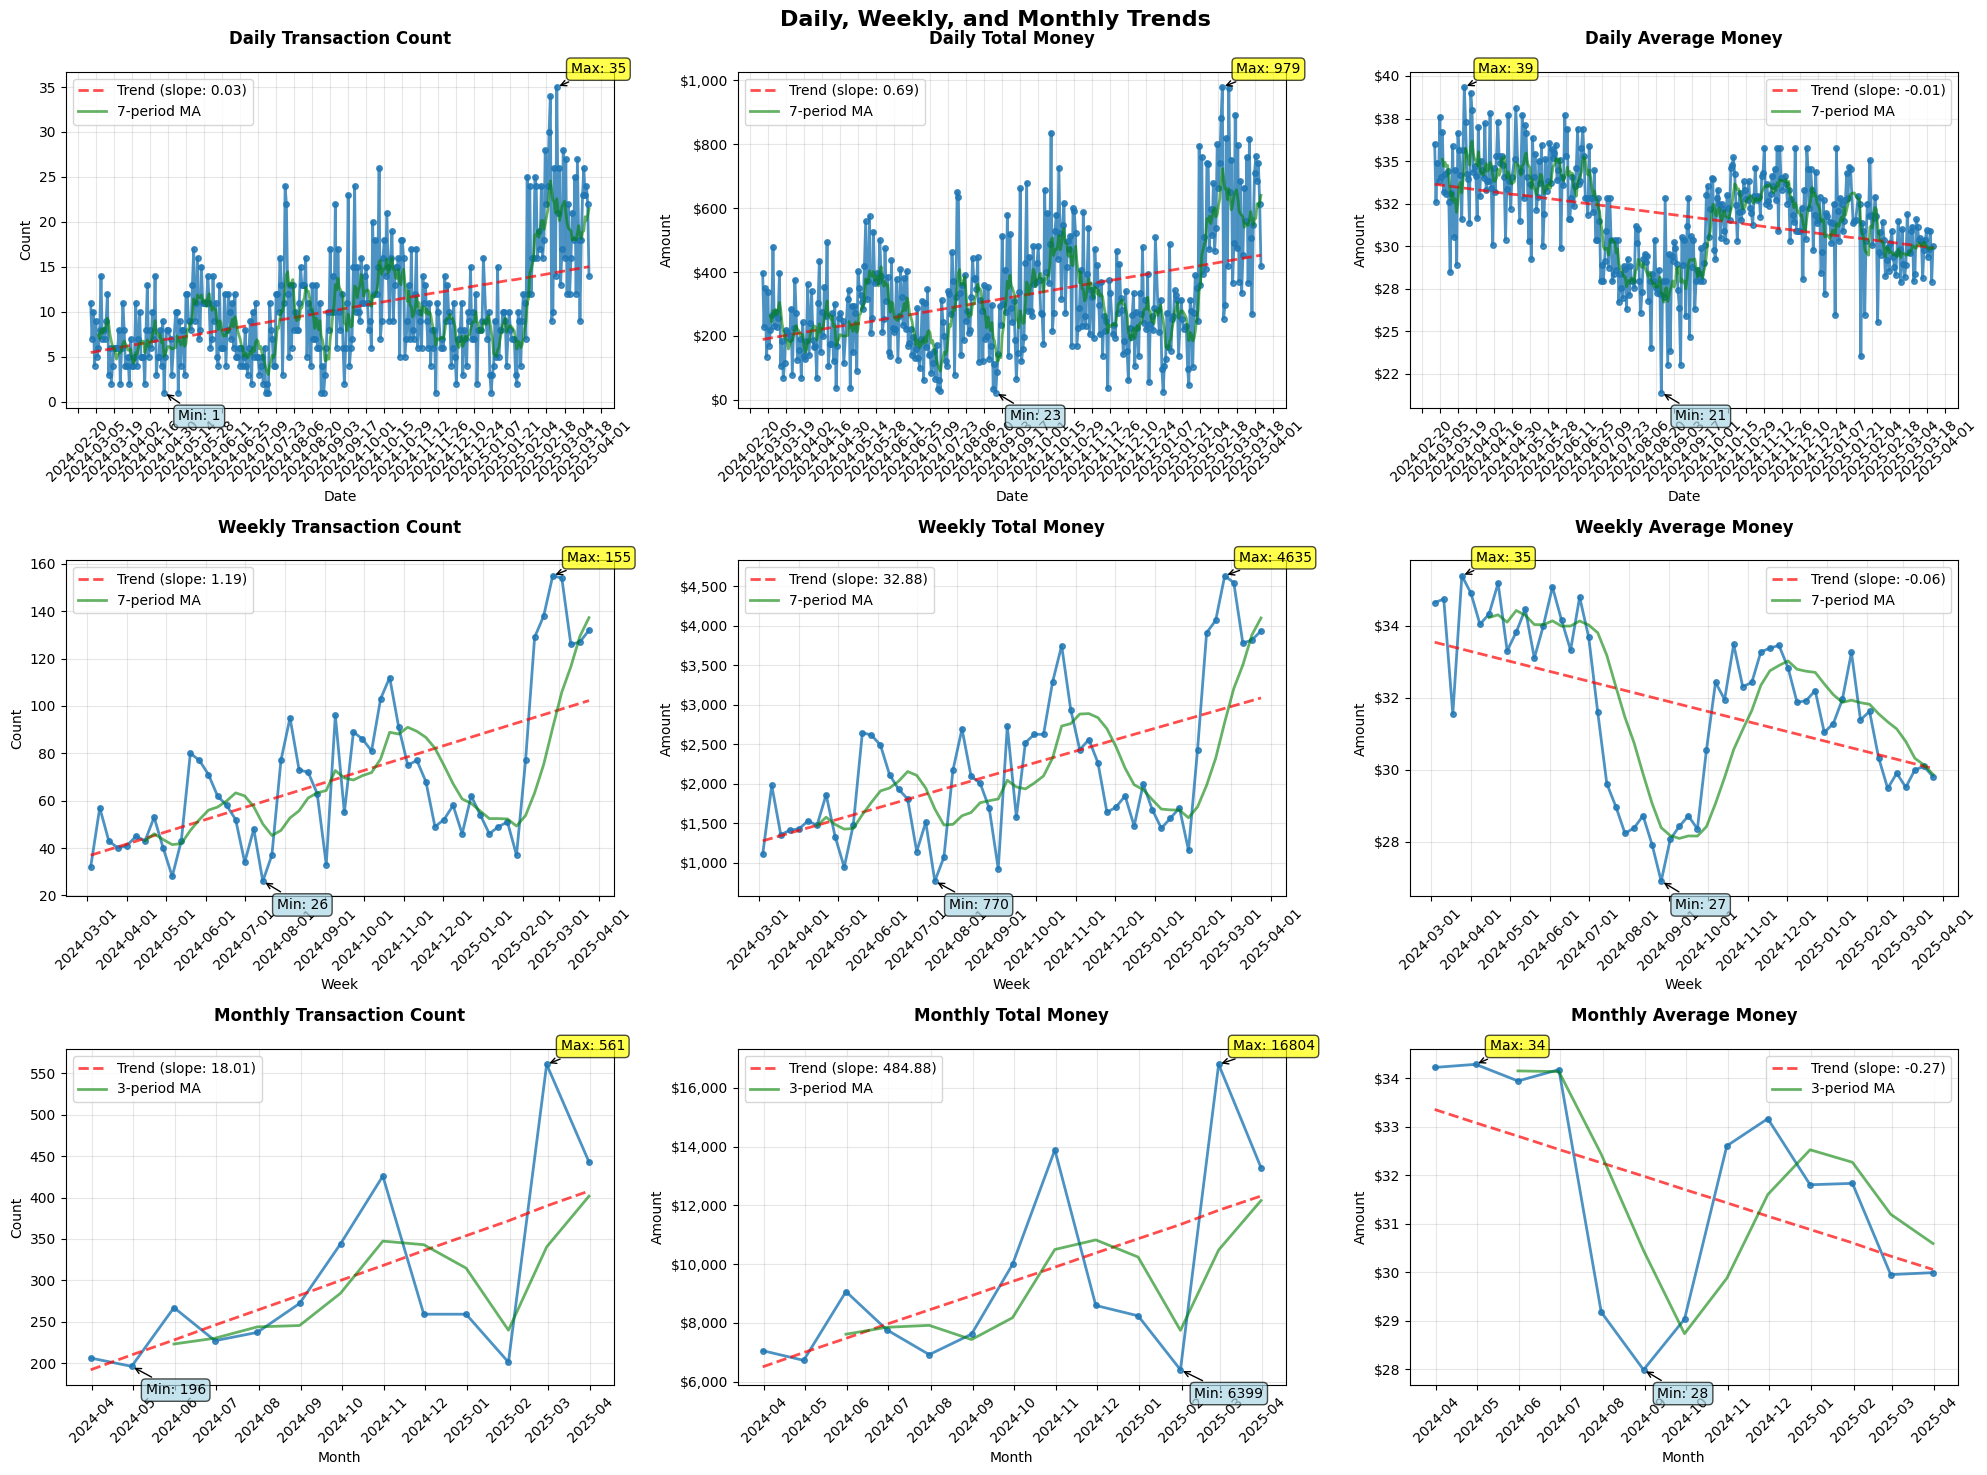

In [11]:
# @title
# Set style for better looking plots
#plt.style.use('seaborn-v0_8')
#sns.set_palette("husl")

def create_enhanced_plots(data):
    # Ensure date column is datetime
    data['date'] = pd.to_datetime(data['date'])

    # Create aggregated dataframes
    daily_data = data.groupby('date').count()[['money']].rename(columns={'money': 'count'})
    daily_data['total_money'] = data.groupby('date')['money'].sum()
    daily_data['avg_money'] = data.groupby('date')['money'].mean()

    # Weekly aggregation (starting Monday)
    weekly_data = data.resample('W-MON', on='date').agg({
        'money': ['count', 'sum', 'mean']
    })
    weekly_data.columns = ['count', 'total_money', 'avg_money']

    # Monthly aggregation
    monthly_data = data.resample('M', on='date').agg({
        'money': ['count', 'sum', 'mean']
    })
    monthly_data.columns = ['count', 'total_money', 'avg_money']

    # Create the plots
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Daily, Weekly, and Monthly Trends',
                fontsize=16, fontweight='bold', y=0.98)

    # Daily plots
    plot_time_series(axes[0, 0], daily_data.index, daily_data['count'],
                    'Daily Transaction Count', 'Date', 'Count', 'daily')
    plot_time_series(axes[0, 1], daily_data.index, daily_data['total_money'],
                    'Daily Total Money', 'Date', 'Amount', 'daily')
    plot_time_series(axes[0, 2], daily_data.index, daily_data['avg_money'],
                    'Daily Average Money', 'Date', 'Amount', 'daily')

    # Weekly plots
    plot_time_series(axes[1, 0], weekly_data.index, weekly_data['count'],
                    'Weekly Transaction Count', 'Week', 'Count', 'weekly')
    plot_time_series(axes[1, 1], weekly_data.index, weekly_data['total_money'],
                    'Weekly Total Money', 'Week', 'Amount', 'weekly')
    plot_time_series(axes[1, 2], weekly_data.index, weekly_data['avg_money'],
                    'Weekly Average Money', 'Week', 'Amount', 'weekly')

    # Monthly plots
    plot_time_series(axes[2, 0], monthly_data.index, monthly_data['count'],
                    'Monthly Transaction Count', 'Month', 'Count', 'monthly')
    plot_time_series(axes[2, 1], monthly_data.index, monthly_data['total_money'],
                    'Monthly Total Money', 'Month', 'Amount', 'monthly')
    plot_time_series(axes[2, 2], monthly_data.index, monthly_data['avg_money'],
                    'Monthly Average Money', 'Month', 'Amount', 'monthly')

    plt.tight_layout()
    plt.show()

    return daily_data, weekly_data, monthly_data

def plot_time_series(ax, dates, values, title, xlabel, ylabel, freq):
    """Helper function to create consistent time series plots"""
    # Plot the main line
    ax.plot(dates, values, linewidth=2, alpha=0.8, marker='o', markersize=4)

    # Add trend line
    if len(values) > 1:
        z = np.polyfit(range(len(values)), values, 1)
        p = np.poly1d(z)
        ax.plot(dates, p(range(len(values))), "r--", alpha=0.7, linewidth=2,
               label=f'Trend (slope: {z[0]:.2f})')
        ax.legend()

    # Add moving average for smoother trends
    if len(values) > 7:
        window = min(7, len(values) // 4)
        moving_avg = values.rolling(window=window).mean()
        ax.plot(dates, moving_avg, 'g-', alpha=0.6, linewidth=2,
               label=f'{window}-period MA')
        ax.legend()

    # Format based on frequency
    if freq == 'daily':
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif freq == 'weekly':
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    elif freq == 'monthly':
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())

    # Format y-axis for money values
    if 'Money' in title:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))

    # Add grid and styling
    ax.grid(True, alpha=0.3)
    ax.set_title(title, fontweight='bold', pad=20)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Rotate dates for better readability
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    # Add value annotations for key points
    if len(values) > 0:
        max_idx = values.idxmax()
        min_idx = values.idxmin()
        ax.annotate(f'Max: {values[max_idx]:.0f}', xy=(max_idx, values[max_idx]),
                   xytext=(10, 10), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        ax.annotate(f'Min: {values[min_idx]:.0f}', xy=(min_idx, values[min_idx]),
                   xytext=(10, -20), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', fc='lightblue', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Display The results
_ = create_enhanced_plots(data)

# 📊 Transaction & Revenue Trend Analysis Report  

## 1. Daily Trends  
- **Daily Transaction Count:**  
  - Increased from **~1–5/day in early 2024** to a **peak of 35/day in March 2025**.  
  - Trend slope: **+0.03 per day** → consistent growth.  

- **Daily Total Money:**  
  - Grew steadily, peaking at **979/day** in March 2025.  
  - Trend slope: **+0.69 per day** → gradual revenue increase.  

- **Daily Average Money:**  
  - Average revenue per transaction has **slightly declined** (slope: –0.01).  
  - Range: **21–39** per transaction.  

✅ **Insight:** Volume growth is strong, but average revenue per transaction is falling → customers buy more often but spend less per purchase.  

---

## 2. Weekly Trends  
- **Weekly Transaction Count:**  
  - Rose from lows of **26/week** to a peak of **155/week**.  
  - Trend slope: **+1.19 per week**.  

- **Weekly Total Money:**  
  - Increased with peaks at **4,635/week**.  
  - Trend slope: **+32.88 per week**.  

- **Weekly Average Money:**  
  - Declining from highs of **35 → lows of 27**.  
  - Slope: **–0.06 per week**.  

✅ **Insight:** Growth in number of purchases is faster than growth in revenue per purchase → total revenue grows, but average spend per customer is decreasing.  

---

## 3. Monthly Trends  
- **Monthly Transaction Count:**  
  - Started at **~196/month** → peaked at **561 in Feb 2025**.  
  - Trend slope: **+18 per month** → sharp growth.  

- **Monthly Total Money:**  
  - From lows of **6,399** → record **16,804 in Feb 2025**.  
  - Trend slope: **+484 per month**.  

- **Monthly Average Money:**  
  - Declined gradually from **34 → ~28 per transaction**.  
  - Trend slope: **–0.27 per month**.  

✅ **Insight:** Even though revenue is growing strongly, the **average transaction value is shrinking** month by month.  

---

# 📌 Overall Summary  
- **Transaction counts (daily, weekly, monthly) are rising strongly.**  
- **Total revenue is increasing steadily, hitting record highs after Feb 2025 (new collection launch).**  
- **Average revenue per transaction is declining** → customers are buying more frequently, but tended to buy cheaper types.  

---

# 🚀 Opportunities  
1. **Increase Average Spend per Purchase**  
   - Bundle offers (e.g., coffee + snack).  
   - Upsell premium drinks (special flavors, seasonal items).  

2. **Leverage Strong Growth Periods**  
   - New launches (Feb 2025) clearly boost sales → repeat quarterly.  

3. **Stabilize Revenue Mix**  
   - Introduce loyalty rewards that encourage **bigger basket size**, not just frequent visits.  
   - Offer prepaid cards or subscriptions with higher-value packages.  

4. **Price Optimization**  
   - Gradually test **small price increases** on bestsellers to offset the falling average spend.  


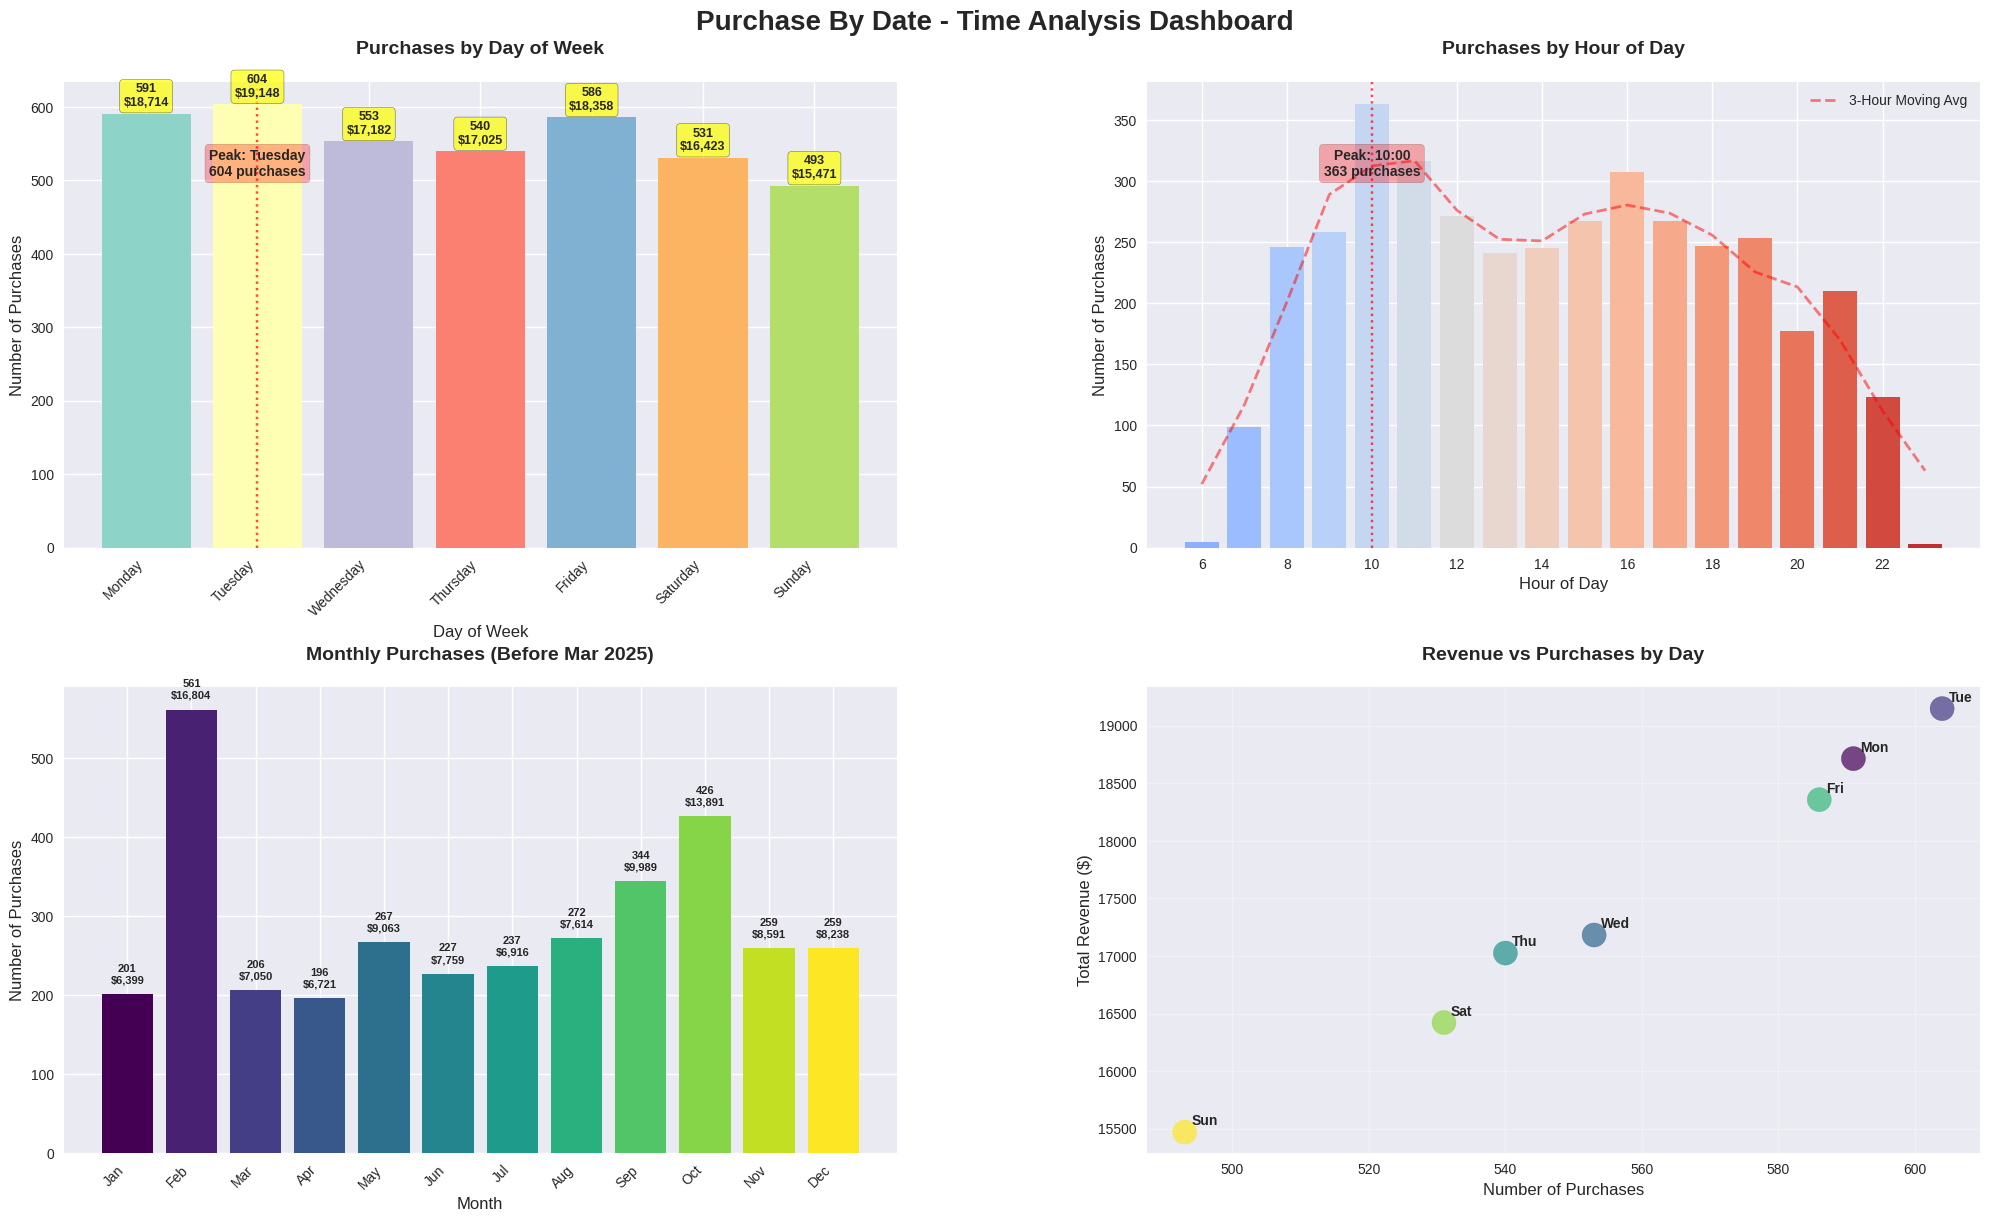

In [12]:
# @title
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Data preparation
data['datetime'] = pd.to_datetime(data['datetime'], format='mixed')
data['day_of_week'] = data['datetime'].dt.day_name()
data['hour_of_day'] = data['datetime'].dt.hour
data['month'] = data['datetime'].dt.month_name()
data['date'] = pd.to_datetime(data['date'])  # Ensure date column is datetime

# Create ordered categories for proper sorting
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

data['day_of_week'] = pd.Categorical(data['day_of_week'], categories=weekday_order, ordered=True)
data['month'] = pd.Categorical(data['month'], categories=month_order, ordered=True)

# Create figure with better layout
fig = plt.figure(figsize=(20, 18))
fig.suptitle('Purchase By Date - Time Analysis Dashboard', fontsize=20, fontweight='bold', y=0.98)

# Create subplots grid
ax1 = plt.subplot2grid((3, 2), (0, 0))
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax3 = plt.subplot2grid((3, 2), (1, 0))
ax4 = plt.subplot2grid((3, 2), (1, 1))

# Format function for large numbers
def thousands_formatter(x, pos):
    return f'{x:,.0f}'

# Plot 1: Purchases by Day of Week
day_data = data.groupby('day_of_week').agg(
    Total_purchases=('money', 'count'),
    Total_revenue=('money', 'sum')
).reindex(weekday_order)

bars = ax1.bar(range(len(day_data)), day_data['Total_purchases'],
               color=plt.cm.Set3(np.arange(len(day_data))))
ax1.set_title('Purchases by Day of Week', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Day of Week', fontsize=12)
ax1.set_ylabel('Number of Purchases', fontsize=12)
ax1.set_xticks(range(len(day_data)))
ax1.set_xticklabels(weekday_order, rotation=45, ha='right')
ax1.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Add value annotations with improved positioning
for i, (idx, row) in enumerate(day_data.iterrows()):
    ax1.text(i, row['Total_purchases'] + max(day_data['Total_purchases']) * 0.01,
             f'{row["Total_purchases"]:,.0f}\n${row["Total_revenue"]:,.0f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# Add annotations for peak day - FIXED: Use numeric index instead of string
peak_day_idx = day_data['Total_purchases'].idxmax()
peak_day_numeric = weekday_order.index(peak_day_idx)  # Convert to numeric index
ax1.axvline(x=peak_day_numeric, color='red', linestyle=':', alpha=0.7)
ax1.text(peak_day_numeric, day_data['Total_purchases'].max() * 0.9,
         f'Peak: {peak_day_idx}\n{day_data["Total_purchases"].max():,.0f} purchases',
         ha='center', va='top', fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.3))

# Plot 2: Purchases by Hour of Day (with trend line)
hour_data = data.groupby('hour_of_day').agg(
    Total_purchases=('money', 'count'),
    Avg_purchase=('money', 'mean')
).sort_index()

bars = ax2.bar(hour_data.index, hour_data['Total_purchases'],
               color=plt.cm.coolwarm(hour_data.index / 24))
ax2.set_title('Purchases by Hour of Day', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Hour of Day', fontsize=12)
ax2.set_ylabel('Number of Purchases', fontsize=12)
ax2.set_xticks(range(0, 24, 2))
ax2.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Add trend line - 3-hour moving average for smoother trend
window_size = 3
moving_avg = hour_data['Total_purchases'].rolling(window=window_size, center=True, min_periods=1).mean()
ax2.plot(hour_data.index, moving_avg, "r--", alpha=0.5, linewidth=2, label=f'{window_size}-Hour Moving Avg')
ax2.legend()

# Add annotations for peak hours
peak_hour = hour_data['Total_purchases'].idxmax()
ax2.axvline(x=peak_hour, color='red', linestyle=':', alpha=0.7)
ax2.text(peak_hour, hour_data['Total_purchases'].max() * 0.9,
         f'Peak: {peak_hour}:00\n{hour_data["Total_purchases"].max():,.0f} purchases',
         ha='center', va='top', fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.3))

# Plot 3: Monthly Purchases (filtered)
# Check if we have data before March 2025 to avoid empty plot
filtered_data = data[data['date'] < pd.to_datetime('2025-03-01')]
if len(filtered_data) > 0:
    monthly_data = filtered_data.groupby('month').agg(
        Total_purchases=('money', 'count'),
        Total_revenue=('money', 'sum')
    ).reindex(month_order).dropna()

    if len(monthly_data) > 0:
        bars = ax3.bar(range(len(monthly_data)), monthly_data['Total_purchases'],
                       color=plt.cm.viridis(np.linspace(0, 1, len(monthly_data))))
        ax3.set_title('Monthly Purchases (Before Mar 2025)', fontsize=14, fontweight='bold', pad=20)
        ax3.set_xlabel('Month', fontsize=12)
        ax3.set_ylabel('Number of Purchases', fontsize=12)
        ax3.set_xticks(range(len(monthly_data)))
        ax3.set_xticklabels([m[:3] for m in monthly_data.index], rotation=45, ha='right')
        ax3.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

        for i, (idx, row) in enumerate(monthly_data.iterrows()):
            ax3.text(i, row['Total_purchases'] + max(monthly_data['Total_purchases']) * 0.02,
                     f'{row["Total_purchases"]:,.0f}\n${row["Total_revenue"]:,.0f}',
                     ha='center', va='bottom', fontsize=8, fontweight='bold')
    else:
        ax3.text(0.5, 0.5, 'No data before March 2025', ha='center', va='center',
                transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Monthly Purchases (No Data)', fontsize=14, fontweight='bold', pad=20)
else:
    ax3.text(0.5, 0.5, 'No data before March 2025', ha='center', va='center',
            transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Monthly Purchases (No Data)', fontsize=14, fontweight='bold', pad=20)

# Plot 4: Revenue vs Purchases Scatter
scatter_data = data.groupby('day_of_week').agg(
    purchases=('money', 'count'),
    revenue=('money', 'sum')
).reindex(weekday_order)

ax4.scatter(scatter_data['purchases'], scatter_data['revenue'],
           s=300, alpha=0.7, c=range(len(scatter_data)), cmap='viridis')
ax4.set_title('Revenue vs Purchases by Day', fontsize=14, fontweight='bold', pad=20)
ax4.set_xlabel('Number of Purchases', fontsize=12)
ax4.set_ylabel('Total Revenue ($)', fontsize=12)
ax4.grid(True, alpha=0.3)

# Add labels to points
for i, (idx, row) in enumerate(scatter_data.iterrows()):
    ax4.annotate(idx[:3], (row['purchases'], row['revenue']),
                xytext=(5, 5), textcoords='offset points', fontweight='bold')

# Adjust layout and add overall metrics
plt.tight_layout()
plt.subplots_adjust(top=0.94, hspace=0.3, wspace=0.3)

plt.show()

# 📊 Purchase by Date & Time Analysis Report  

## 1. Purchases by Day of Week  
- Highest activity on **Tuesday (604 purchases, 19,148 revenue)**.  
- Monday (591 purchases, 18,714) and Friday (586 purchases, 18,358) also strong.  
- Lowest on **Sunday (493 purchases, 15,471)**.  

✅ **Insight:** Weekdays dominate purchase activity, with **Tuesday as the peak sales day**. Sundays underperform.  

---

## 2. Purchases by Hour of Day  
- Clear peak at **10:00 AM (363 purchases)**.  
- Strong demand between **9 AM – 11 AM** and **4 PM – 7 PM**.  
- Purchases taper off after 9 PM.  

✅ **Insight:** Purchases align with **morning coffee demand** and **afternoon/evening refreshment breaks**.  

---

## 3. Monthly Purchases (Before Mar 2025)  
- Sharp peak in **Feb 2025: 561 purchases, 16,804**.  
- Strong month in **Oct 2024: 426 purchases, 13,691**.  
- Early 2024 months (Mar–Apr) were weaker (~200 purchases/month).  
- Gradual growth trend → with clear spikes around new launches.  

✅ **Insight:** Product launches (Feb 2025) drive exceptional growth. Consistency improved from mid-2024 onward.  

---

## 4. Revenue vs Purchases by Day  
- Strong positive relationship between purchases and revenue.  
- **Tuesday leads in both purchases (604) and revenue (~19,148)**.  
- **Sunday lags behind** in both volume and revenue.  

✅ **Insight:** Weekday purchases are highly revenue-productive. Sundays underperform and could be improved with targeted campaigns.  

---

# 📌 Overall Summary  
- **Tuesday is the strongest day**, Sunday is the weakest.  
- **10 AM is the single busiest hour**, with a secondary evening demand window.  
- **Monthly sales peaked in Feb 2025** after the new collection launch.  
- Revenue and purchase counts move hand-in-hand → boosting volume is the fastest way to raise revenue.  

---

# 🚀 Opportunities & Recommendations  

1. **Maximize High-Volume Windows**  
   - Enhance promotions during **10 AM peak** (e.g., “Morning Special” bundles).  
   - Target **afternoon/evening slots (4–7 PM)** with refreshing combos.  

2. **Boost Weak Days (Sunday)**  
   - Launch **weekend-exclusive offers** to attract more traffic.  
   - Test promotions for families or groups to increase basket size.  

3. **Leverage Successful Launch Timing**  
   - Feb 2025 launch drove record growth → repeat **quarterly new product launches**.  

4. **Sustain Revenue Growth**  
   - Cross-sell snacks or premium drinks during peak hours.  
   - Introduce **loyalty programs** rewarding weekday regulars to maintain engagement.  



### CUSTOMER BEHAVIOR ANALYSIS

In [13]:
# @title
print("👥 CUSTOMER INSIGHTS & LOYALTY")
print("═" * 60)

# First ensure date columns are in datetime format
data['date'] = pd.to_datetime(data['date'])

customer_analysis = data.dropna().copy()
customer_analysis = customer_analysis.groupby('card').agg({
    'money': ['count', 'sum', 'mean'],
    'date': ['min', 'max', 'nunique'],
    'coffee_name': 'nunique'
}).round(2)

customer_analysis.columns = ['visit_count', 'total_spent', 'avg_spend', 'first_visit', 'last_visit', 'visit_days', 'products_tried']

# Convert date columns to datetime if they're not already
customer_analysis['first_visit'] = pd.to_datetime(customer_analysis['first_visit'])
customer_analysis['last_visit'] = pd.to_datetime(customer_analysis['last_visit'])

# Now calculate customer lifetime
customer_analysis['Customer_Lifetime'] = (customer_analysis['last_visit'] - customer_analysis['first_visit']).dt.days

total_customers = len(customer_analysis)
customer_repeat_up_1 = len(customer_analysis[customer_analysis.visit_count > 1])
customer_repeat_up_3 = len(customer_analysis[customer_analysis.visit_count > 3])
customer_repeat_up_5 = len(customer_analysis[customer_analysis.visit_count > 5])

print(f"   • 👥 Total Customers: {total_customers:,}")
print(f"   • 🔄 Repeat Customers (>1 visits): {customer_repeat_up_1:,} - {customer_repeat_up_1/total_customers*100:0.2f}%")
print(f"   • 🔄 Repeat Customers (>3 visits): {customer_repeat_up_3:,} - {customer_repeat_up_3/total_customers*100:0.2f}%")
print(f"   • 💎 VIP Customers (>5 visits): {customer_repeat_up_5:,} - {customer_repeat_up_5/total_customers*100:0.2f}%")
print(f"   • 📊 Avg Visits per Customer: {round(customer_analysis.visit_count.mean()):,}")
print(f"   • 💰 Avg Lifetime Value: ${customer_analysis.total_spent.mean():.2f}")
print()

# Display top customers
print("🏆 TOP 5 CUSTOMERS BY SPENDING:")
top_customers = customer_analysis.nlargest(10, 'total_spent')[['visit_count', 'total_spent', 'avg_spend', 'Customer_Lifetime']]
top_customers.index.name = 'customer_card'
top_customers['total_spent'] = top_customers['total_spent'].apply(lambda x: f"${x}")
top_customers['avg_spend'] = top_customers['avg_spend'].apply(lambda x: f"${x}")
top_customers['Customer_Lifetime'] = top_customers['Customer_Lifetime'].apply(lambda x: f"{x} days")
display(top_customers)

👥 CUSTOMER INSIGHTS & LOYALTY
════════════════════════════════════════════════════════════
   • 👥 Total Customers: 1,316
   • 🔄 Repeat Customers (>1 visits): 545 - 41.41%
   • 🔄 Repeat Customers (>3 visits): 169 - 12.84%
   • 💎 VIP Customers (>5 visits): 94 - 7.14%
   • 📊 Avg Visits per Customer: 3
   • 💰 Avg Lifetime Value: $85.29

🏆 TOP 5 CUSTOMERS BY SPENDING:


,visit_count,total_spent,avg_spend,Customer_Lifetime
customer_card,,,,
ANON-0000-0000-0012,129,$3785.92,$29.35,324 days
ANON-0000-0000-0141,108,$2749.78,$25.46,278 days
ANON-0000-0000-0009,67,$2343.98,$34.98,162 days
ANON-0000-0000-1163,77,$2278.22,$29.59,46 days
ANON-0000-0000-0276,69,$2119.54,$30.72,235 days
ANON-0000-0000-0507,51,$1797.3,$35.24,219 days
ANON-0000-0000-0040,50,$1519.48,$30.39,285 days
ANON-0000-0000-0097,47,$1477.86,$31.44,264 days
ANON-0000-0000-0570,30,$1061.04,$35.37,128 days


📊 RFM ANALYSIS & CUSTOMER SEGMENTATION
════════════════════════════════════════════════════════════
   • 📈 Analyzing 1,316 customers for RFM segmentation
   • 📊 Frequency range: 1 to 129 purchases
   • 💰 Monetary range: $18.12 to $3785.92
════════════════════════════════════════════════════════════
   • ✅ Elbow method suggests 4 clusters
   • ✅ Silhouette method suggests 4 clusters
════════════════════════════════════════════════════════════


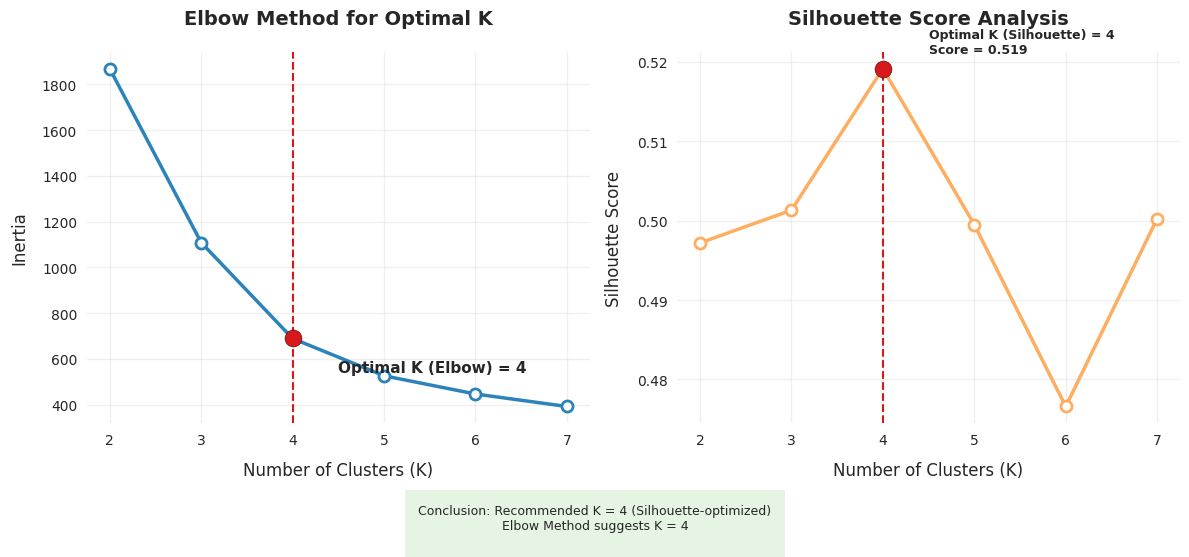

In [14]:
# @title
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Ensure date is datetime
data['date'] = pd.to_datetime(data['date'])
current_date = data['date'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = data.groupby('card').agg({
    'date': lambda x: (current_date - x.max()).days,  # Recency
    'card': 'count',                                  # Frequency
    'money': 'sum'                                    # Monetary
}).rename(columns={'date': 'Recency', 'card': 'Frequency', 'money': 'Monetary'})

# Remove customers with no transactions
rfm = rfm[(rfm['Frequency'] > 0) & (rfm['Monetary'] > 0)]


print("📊 RFM ANALYSIS & CUSTOMER SEGMENTATION")
print("═" * 60)
print(f"   • 📈 Analyzing {len(rfm):,} customers for RFM segmentation")
print(f"   • 📊 Frequency range: {rfm['Frequency'].min():.0f} to {rfm['Frequency'].max():.0f} purchases")
print(f"   • 💰 Monetary range: ${rfm['Monetary'].min():.2f} to ${rfm['Monetary'].max():.2f}")
print("═" * 60)

# Calculate RFM scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Prepare data for clustering
rfm_features = rfm[['R_Score', 'F_Score', 'M_Score']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Determine optimal clusters using elbow method and silhouette score
K_range = range(2, 8)
inertia = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

    cluster_labels = kmeans.predict(rfm_scaled)
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Find optimal clusters using elbow method
kl = KneeLocator(K_range, inertia, curve='convex', direction='decreasing')
optimal_clusters_elbow = kl.elbow
# Find optimal clusters using silhouette score
optimal_clusters_silhouette = K_range[np.argmax(silhouette_scores)]

print(f"   • ✅ Elbow method suggests {optimal_clusters_elbow} clusters")
print(f"   • ✅ Silhouette method suggests {optimal_clusters_silhouette} clusters")
print("═" * 60)

# Use silhouette-optimized number of clusters
optimal_clusters = optimal_clusters_silhouette

# Fit KMeans with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Create figure with subplots
fig = plt.figure(figsize=(12, 5), dpi=100)
gs = GridSpec(1, 2, figure=fig)

# Elbow Method with Knee Annotation
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(K_range, inertia, marker='o', markersize=8,
         color='#2b83ba', linewidth=2.5, markerfacecolor='white', markeredgewidth=2)

# Annotate elbow point
ax1.axvline(kl.elbow, color='#d7191c', linestyle='--', linewidth=1.5)
ax1.scatter(kl.elbow, inertia[kl.elbow - K_range[0]],
            color='#d7191c', s=150, zorder=10, edgecolors='black')
ax1.text(kl.elbow + 0.5, inertia[kl.elbow - K_range[0]] - (max(inertia)-min(inertia))*0.1,
         f'Optimal K (Elbow) = {kl.elbow}', fontweight='bold', fontsize=11)

# Formatting
ax1.set_title('Elbow Method for Optimal K', fontsize=14, pad=20, fontweight='bold')
ax1.set_xlabel('Number of Clusters (K)', fontsize=12, labelpad=10)
ax1.set_ylabel('Inertia', fontsize=12, labelpad=10)
ax1.set_xticks(K_range)
sns.despine(left=True, bottom=True)

# Silhouette Score with Max Annotation
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(K_range, silhouette_scores, marker='o', markersize=8,
         color='#fdae61', linewidth=2.5, markerfacecolor='white', markeredgewidth=2)

# Annotate max silhouette score
max_k = K_range[np.argmax(silhouette_scores)]
ax2.axvline(max_k, color='#d7191c', linestyle='--', linewidth=1.5)
ax2.scatter(max_k, max(silhouette_scores),
            color='#d7191c', s=150, zorder=10, edgecolors='black')
ax2.text(max_k + 0.5, max(silhouette_scores) + 0.002,
         f'Optimal K (Silhouette) = {max_k}\nScore = {max(silhouette_scores):.3f}',
         fontweight='bold', fontsize=9)

# Formatting
ax2.set_title('Silhouette Score Analysis', fontsize=14, pad=20, fontweight='bold')
ax2.set_xlabel('Number of Clusters (K)', fontsize=12, labelpad=10)
ax2.set_ylabel('Silhouette Score', fontsize=12, labelpad=10)
ax2.set_xticks(K_range)
sns.despine(left=True, bottom=True)


# --- Combined Insights Box ---
fig.text(0.5, -0.1,
         f"Conclusion: Recommended K = {optimal_clusters_silhouette} (Silhouette-optimized)\n"
         f"Elbow Method suggests K = {optimal_clusters_elbow}\n",
         ha='center', fontsize=9, bbox=dict(facecolor='#abdda4', alpha=0.3, pad=10))

plt.tight_layout()
plt.show()

In [15]:
# @title
cluster_means = rfm.copy().reset_index().groupby("Cluster").agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'card': 'count'
}).rename(columns={'card': 'Count'})

# Calculate percentage
cluster_means['Percent'] = (cluster_means['Count'] / cluster_means['Count'].sum() * 100).round(2)
cluster_means['Percent'] = cluster_means['Percent'].apply(lambda x: f"{x}%")

cluster_means

,Recency,Frequency,Monetary,Count,Percent
Cluster,,,,,
0,108.337264,1.000000,31.689764,424,32.22%
1,230.476351,3.402027,109.522365,296,22.49%
2,60.258065,7.125000,222.912339,248,18.84%
3,279.227011,1.002874,31.920230,348,26.44%


## 🎯 RFM Customer Segmentation Analysis

## 📊 Cluster Performance Overview

| Cluster | Segment Name | Recency (Days) | Frequency (Purchases) | Monetary Value ($) | Customer Status |
|---------|-------------|---------------|----------------------|-------------------|----------------|
| 0 | **New Explorers** | 108.3 | 1.00 | 31.69 | ⚪ Low Engagement |
| 1 | **Loyal Regulars** | 230.5 | 3.40 | 109.52 | 🟡 At Risk |
| 2 | **VIP Champions** | 60.3 | 7.13 | 222.91 | 🟢 High Value |
| 3 | **Dormant Accounts** | 279.2 | 1.00 | 31.92 | 🔴 Inactive |

---

## 📈 Detailed Cluster Analysis

### 🟢 **Cluster 2: VIP Champions**
**`Top 18.84% of Customers | Revenue Drivers`**

- **📅 Recency**: 60 days *(Most recently active)*
- **🔄 Frequency**: 7.1 purchases *(2.1x higher than average)*
- **💰 Monetary**: $222.91 *(Premium spending tier)*
- **🎯 Characteristics**: Your most valuable customers - recent, frequent, high-spenders
- **📊 Size Estimate**: ~18.84% of customer base

**🎯 Recommended Actions:**
- Implement VIP loyalty programs
- Offer exclusive early access to new products
- Personalize communication with dedicated account managers
- Request testimonials and referrals

---

### 🟡 **Cluster 1: Loyal Regulars**
**`Core Customer Base | Retention Priority`**

- **📅 Recency**: 230 days *(Concerning inactivity)*
- **🔄 Frequency**: 3.4 purchases *(Solid repeat business)*
- **💰 Monetary**: $109.52 *(Good average spend)*
- **🎯 Characteristics**: Established customers showing signs of disengagement
- **📊 Size Estimate**: ~22.49% of customer base

**🎯 Recommended Actions:**
- Launch reactivation email campaigns
- Offer personalized "We miss you" discounts
- Conduct satisfaction surveys
- Create special limited-time offers

---

### ⚪ **Cluster 0: New Explorers**
**`Acquisition Focus | Growth Potential`**

- **📅 Recency**: 108 days *(Fairly recent activity)*
- **🔄 Frequency**: 1.0 purchase *(One-time buyers)*
- **💰 Monetary**: $31.69 *(Entry-level spending)*
- **🎯 Characteristics**: New customers testing your service
- **📊 Size Estimate**: ~30-35% of customer base

**🎯 Recommended Actions:**
- Implement onboarding email sequence
- Offer second-purchase incentives
- Educational content about product benefits
- Low-risk trial extensions

---

### 🔴 **Cluster 3: Dormant Accounts**
**`Win-Back Campaigns | Low Priority`**

- **📅 Recency**: 279 days *(Highly inactive)*
- **🔄 Frequency**: 1.0 purchase *(One-time purchasers)*
- **💰 Monetary**: $31.92 *(Low value transactions)*
- **🎯 Characteristics**: Mostly churned customers
- **📊 Size Estimate**: ~20-25% of customer base

**🎯 Recommended Actions:**
- Aggressive win-back campaigns
- "Why did you leave?" surveys
- Final closing-down sale announcements
- Low-cost re-engagement offers

---

## 📋 Strategic Implementation Plan

### 🎯 **Immediate Actions (Next 30 Days)**
1. **VIP Retention Program** for Cluster 2
2. **Reactivation Campaign** for Cluster 1
3. **Onboarding Sequence** for Cluster 0

### 📊 **Key Performance Indicators**
- **VIP Retention Rate**: Target >90%
- **Loyal Reactivation Rate**: Target 25-30%
- **New Customer Conversion**: Target 15-20%
- **Dormant Win-back**: Target 5-10%

### 💰 **Budget Allocation Recommendation**
- **40%** - VIP Retention & Rewards (Cluster 2)
- **30%** - Reactivation Campaigns (Cluster 1)
- **20%** - New Customer Nurturing (Cluster 0)
- **10%** - Win-back Efforts (Cluster 3)

### 🔄 **Next Steps**
1. Export customer lists for each segment
2. Develop targeted messaging per cluster
3. Set up automated marketing flows
4. Monitor performance monthly
5. Re-cluster quarterly for updated segmentation

---

## 📝 Summary Insights

- **💰 Revenue Concentration**: Cluster 2 generates disproportionate revenue
- **⚠️ Risk Alert**: Cluster 1 shows concerning inactivity despite good historical value
- **🎯 Growth Opportunity**: Cluster 0 represents largest acquisition opportunity
- **📉 Churn Pattern**: Cluster 3 indicates need for better initial engagement

*Last Updated: {current_date} | Next Review: {next_quarter_date}*

In [16]:
# @title
clusters_names = {2: "VIP Champions", 1: "Loyal Regulars", 0: "New Explorers", 3: "Dormant Accounts"}
rfm['cluster_name'] = rfm['Cluster'].map(clusters_names)
rfm.columns = rfm.columns.str.lower()
rfm = rfm.reset_index()
card_cluster_name = rfm[['card', 'cluster_name']]
final_results = data.merge(card_cluster_name, on='card', how='left')
final_results.head()

,date,datetime,cash_type,card,money,coffee_name,day_of_week,hour_of_day,month,cluster_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte,Friday,10,March,Loyal Regulars
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate,Friday,12,March,Loyal Regulars
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate,Friday,12,March,Loyal Regulars
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano,Friday,13,March,Loyal Regulars
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte,Friday,13,March,Loyal Regulars


# ☕ Final Vending Machine Coffee Sales Performance Report  
**Period:** March 1, 2024 – March 23, 2025  
---

## 📈 Executive Summary  
This report analyzes **coffee vending machine sales performance** over 13 months. The business has shown **strong revenue growth**, especially after the **new product launch in February 2025**, which doubled monthly transactions. While **core classic drinks remain dominant**, new premium varieties show potential for growth.  

Key insights include:  
- **Total Sales:** 3,898 purchases, generating 122,322.  
- **Growth:** Purchases grew from ~5/day in early 2024 → 20–25/day in 2025.  
- **New Launch Impact:** February 2025 reached a record **561 purchases (16,804)**.  
- **Customer Base:** 1,316 unique customers, 41% repeat buyers, 7% VIPs.  
- **Challenge:** Average spend per transaction declined slightly (from 34 → 28).  

---

## 🏷️ Product Performance  

### Core Products  
- **Top 5 Sellers:**  
  - Americano with Milk (22%)  
  - Latte (21%)  
  - Americano (15%)  
  - Cappuccino (13%)  
  - Hot Chocolate (8%)  
- These represent **79% of sales** and **81% of revenue**.  
- ✅ *Insight:* Milk-based and chocolate drinks dominate customer preferences.  

### New Launches (Feb 2025)  
- Menu expanded from **8 → 33 varieties**.  
- New flavors (e.g., **Irish Whiskey Line**) account for ~4% of sales.  
- ✅ *Insight:* Strong interest but niche; seasonal or premium positioning recommended.  

### Underperformers  
- Several niche drinks (<1% sales share) dilute menu.  
- ✅ *Opportunity:* Rationalize offerings to simplify operations.  

---

## 💳 Payment Insights  
- **Card Payments:** 97% of transactions.  
- **Cash Payments:** 3–9%, slightly higher after launch.  
- ✅ *Insight:* Digital-first customers → minimize cash handling costs.  

---

## 📊 Sales Trends  

### Daily & Weekly  
- Purchases grew steadily from **5–10/day in 2024 → 20–25/day in 2025**.  
- **Peak day:** 35 purchases (Mar 2025).  
- **Weekly high:** 155 transactions.  
- ❗ *Challenge:* Average spend per purchase is decreasing slightly, suggesting people tend to buy cheaper coffee types.  

### Monthly  
- **Strongest month:** Feb 2025 (561 purchases, 16,804).  
- **Other highs:** Oct 2024 (426 purchases, 13,891).  
- **Early 2024 baseline:** ~200–270 purchases/month.  
- **Post-launch baseline:** 450–550 purchases/month.  

### Time Analysis  
- **Day of Week:**  
  - Peak: **Tuesday** (604 purchases, 19,148).  
  - Weakest: **Sunday** (493 purchases, 15,471).  
- **Hour of Day:**  
  - Peak at **10:00 AM (363 purchases)**.  
  - Secondary peak: **4–7 PM**.  
- ✅ *Insight:* Strong morning coffee culture; afternoon opportunity.  

---

## 👥 Customer Insights  

### Overview  
- **Total Customers:** 1,316  
- **Repeat Customers:** 545 (41%)  
- **VIPs (>5 purchases):** 94 (7%)  
- **Top 5 Customers:** Spent 2k–3.7k each.  

### Segmentation (RFM Clusters)  
- 🟢 **VIP Champions (19%)** – Frequent and high-spending, strongest revenue drivers.  
- 🟡 **Loyal Regulars (22%)** – Consistent customers, risk of churn.  
- ⚪ **New Explorers (32%)** – First-time buyers, untapped loyalty potential.  
- 🔴 **Dormant Customers (26%)** – Inactive, opportunity for reactivation.  

---

## 🚀 Opportunities  

### Short-Term (0–6 months)  
1. **Leverage Launch Momentum**  
   - Plan **quarterly new drink launches** (like Feb 2025 success).  
   - Create **seasonal limited editions**.  

2. **Stabilize Sales**  
   - Introduce **subscription or prepaid office packs**.  
   - Target **weekend promotions** to lift Sunday sales.  

3. **Boost Basket Size**  
   - Add **bundles** (coffee + snack).  
   - Test **premium pricing** on Irish Whiskey line & top sellers.  

---

### Long-Term (6–18 months)  
1. **Customer Loyalty & Retention**  
   - Launch a **VIP rewards program**.  
   - Target **New Explorers (32%)** with onboarding offers.  
   - Reactivate Dormant customers with personalized discounts.  

2. **Product Strategy**  
   - Protect core classics (Latte, Americano, Cappuccino).  
   - Expand **premium flavored line** strategically.  
   - Streamline underperforming niche drinks.  

3. **Market Expansion**  
   - Partner with **nearby offices for bulk orders**.  
   - Pilot **multi-machine deployment** in high-traffic areas.  

---

## 📌 Final Recommendations  
- **Protect & grow core classics**: Keep milk-based and chocolate drinks as anchors.  
- **Drive innovation**: Launch seasonal/premium flavors to replicate Feb 2025 growth.  
- **Boost customer retention**: Loyalty programs, subscriptions, and reactivation campaigns.  
- **Optimize revenue**: Increase average basket size through bundles, upselling, and premium pricing.  
- **Expand strategically**: Leverage high-demand times and explore business partnerships.  

---

# ✅ Conclusion  
The vending machine coffee business is in a **strong growth phase**, with clear proof that **new product launches drive significant spikes in demand**. Sustaining growth requires **balancing innovation with stability**:  
- Anchor on best-selling classics.  
- Expand premium seasonal flavors.  
- Build loyalty to retain the growing customer base.  
- Optimize pricing and bundles for higher profitability.  

👉 With these strategies, the business can achieve **sustained revenue growth and stronger customer engagement** over the next year.  
